In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import gridspec
from datetime import datetime
from scipy import interpolate
from scipy import integrate
import scipy.stats
import numpy.ma as ma
import numpy as np
from matplotlib import gridspec
import warnings
warnings.filterwarnings(action='ignore')
from scipy.stats import kde
import trackpy as tp
import glob
import os
import rasterio
import seaborn as sns
import pims
dem_files = sorted(glob.glob('/data/accp/a/snesbitt/relampago/srtm/*.tif'))
ds_list = []
for file in dem_files:
   ds_list.append(xr.open_rasterio(file).isel(band=0))
import metpy.calc as mpcalc
from metpy.units import units
from geopy import distance


In [2]:
gpd_jan25 = pd.read_csv('/data/keeling/a/melinda3/accp/tracking_ots/ot_trajectories_trackpy_filtered_final.csv')
gpd_jan25
 

Unnamed: 0.1  Unnamed: 0                           time        lat  \
0              3914           0  2018-11-05 00:00:57.000000512 -33.508930   
1              3915           1  2018-11-05 00:00:57.000000512 -34.330357   
2              3916           2  2018-11-05 00:00:57.000000512 -34.812500   
3              3917           3  2018-11-05 00:01:57.000000512 -33.491070   
4              3918           4  2018-11-05 00:01:57.000000512 -34.348217   
...             ...         ...                            ...        ...   
31122         12497          16  2019-02-11 05:49:21.000000512 -30.866072   
31123         12498          17  2019-02-11 06:55:20.999999488 -31.062498   
31124         12499          18  2019-02-11 06:56:21.000000512 -30.883930   
31125         12500          19  2019-02-11 09:05:20.999999488 -30.883930   
31126         12501          20  2019-02-11 09:06:20.999999488 -30.901785   

             lon   lat_corr   lon_corr  otid      mintb  tropopause_height  \
0     -64.508934 -33.388930 -64.548935  15.0  204.25000          15.821001   
1     -65.562500 -34.205357 -65.599500  37.0  201.95000          14.893001   
2     -65.241070 -34.688500 -65.279076  64.0  203.19000          14.362000   
3     -64.526790 -33.373070 -64.566790  17.0  205.31999          15.824000   
4     -65.580350 -34.222218 -65.617355  38.0  201.65999          14.882001   
...          ...        ...        ...   ...        ...                ...   
31122 -64.276790 -30.744072 -64.321785   2.0  189.37999          16.827002   
31123 -61.991070 -30.939499 -62.045070   7.0  190.01999          16.798000   
31124 -62.294647 -30.762930 -62.347650   4.0  191.06000          16.823000   
31125 -60.401787 -30.764930 -60.460785   2.0  192.03000          16.690000   
31126 -60.383926 -30.783785 -60.442924   4.0  193.09999          16.688002   

       ...                         diff    frame  states  label  \
0      ...    4 days 00:00:57.000000512        0       0      0   
1      ...    4 days 00:00:57.000000512        0       0      0   
2      ...    4 days 00:00:57.000000512        0       0      0   
3      ...    4 days 00:01:57.000000512       60       0      0   
4      ...    4 days 00:01:57.000000512       60       0      0   
...    ...                          ...      ...     ...    ...   
31122  ...  102 days 05:49:21.000000512  8488104       0      0   
31123  ...  102 days 06:55:20.999999488  8492063       0      0   
31124  ...  102 days 06:56:21.000000512  8492124       0      0   
31125  ...  102 days 09:05:20.999999488  8499863       0      0   
31126  ...  102 days 09:06:20.999999488  8499923       0      0   

                   x              y        date hour particle    cell  
0     -186252.771818 -113957.182952  2018-11-05    0        0     1.0  
1     -281195.211761 -207614.473616  2018-11-05    0        1     2.0  
2     -250256.683854 -260397.992068  2018-11-05    0        2     3.0  
3     -187946.438440 -112002.942262  2018-11-05    0        0     1.0  
4     -282773.895291 -209647.669965  2018-11-05    0        1     2.0  
...              ...            ...         ...  ...      ...     ...  
31122 -169598.851512  180287.613917  2019-02-11    5     8610     NaN  
31123   48480.905512  159729.906504  2019-02-11    6     8611     NaN  
31124   19599.155073  179680.596664  2019-02-11    6     8612     NaN  
31125  200235.892144  177750.897733  2019-02-11    9     8613  8614.0  
31126  201901.948939  175732.453031  2019-02-11    9     8613  8614.0  

[31127 rows x 62 columns]

In [3]:
times = gpd_jan25.time
hours = []
months = []
for time in times:
   test = datetime.strptime(time[0:19], '%Y-%m-%d %H:%M:%S')
   hours.append(test.hour)
   months.append(test.month)

In [4]:
times_dt = pd.to_datetime(times)
gpd_jan25.index = times_dt
st_times = gpd_jan25.index.strftime('%Y-%m-%d %H:%M:%S')
gpd_jan25['time_conv'] = st_times

In [5]:
gpd_jan25.dropna(subset=['cell'])

Unnamed: 0.1  Unnamed: 0  \
time                                                      
2018-11-05 00:00:57.000000512          3914           0   
2018-11-05 00:00:57.000000512          3915           1   
2018-11-05 00:00:57.000000512          3916           2   
2018-11-05 00:01:57.000000512          3917           3   
2018-11-05 00:01:57.000000512          3918           4   
...                                     ...         ...   
2019-02-11 04:57:20.999999488         12493          12   
2019-02-11 04:58:20.999999488         12495          14   
2019-02-11 04:59:20.999999488         12496          15   
2019-02-11 09:05:20.999999488         12500          19   
2019-02-11 09:06:20.999999488         12501          20   

                                                        time        lat  \
time                                                                      
2018-11-05 00:00:57.000000512  2018-11-05 00:00:57.000000512 -33.508930   
2018-11-05 00:00:57.000000512  2018-11-05 00:00:57.000000512 -34.330357   
2018-11-05 00:00:57.000000512  2018-11-05 00:00:57.000000512 -34.812500   
2018-11-05 00:01:57.000000512  2018-11-05 00:01:57.000000512 -33.491070   
2018-11-05 00:01:57.000000512  2018-11-05 00:01:57.000000512 -34.348217   
...                                                      ...        ...   
2019-02-11 04:57:20.999999488  2019-02-11 04:57:20.999999488 -31.258928   
2019-02-11 04:58:20.999999488  2019-02-11 04:58:20.999999488 -31.258928   
2019-02-11 04:59:20.999999488  2019-02-11 04:59:20.999999488 -31.258928   
2019-02-11 09:05:20.999999488  2019-02-11 09:05:20.999999488 -30.883930   
2019-02-11 09:06:20.999999488  2019-02-11 09:06:20.999999488 -30.901785   

                                     lon   lat_corr   lon_corr  otid  \
time                                                                   
2018-11-05 00:00:57.000000512 -64.508934 -33.388930 -64.548935  15.0   
2018-11-05 00:00:57.000000512 -65.562500 -34.205357 -65.599500  37.0   
2018-11-05 00:00:57.000000512 -65.241070 -34.688500 -65.279076  64.0   
2018-11-05 00:01:57.000000512 -64.526790 -33.373070 -64.566790  17.0   
2018-11-05 00:01:57.000000512 -65.580350 -34.222218 -65.617355  38.0   
...                                  ...        ...        ...   ...   
2019-02-11 04:57:20.999999488 -64.633934 -31.136929 -64.676930   4.0   
2019-02-11 04:58:20.999999488 -64.616066 -31.136929 -64.659065   4.0   
2019-02-11 04:59:20.999999488 -64.616066 -31.138927 -64.658066   4.0   
2019-02-11 09:05:20.999999488 -60.401787 -30.764930 -60.460785   2.0   
2019-02-11 09:06:20.999999488 -60.383926 -30.783785 -60.442924   4.0   

                                   mintb  tropopause_height  ...    frame  \
time                                                         ...            
2018-11-05 00:00:57.000000512  204.25000          15.821001  ...        0   
2018-11-05 00:00:57.000000512  201.95000          14.893001  ...        0   
2018-11-05 00:00:57.000000512  203.19000          14.362000  ...        0   
2018-11-05 00:01:57.000000512  205.31999          15.824000  ...       60   
2018-11-05 00:01:57.000000512  201.65999          14.882001  ...       60   
...                                  ...                ...  ...      ...   
2019-02-11 04:57:20.999999488  191.76999          16.865002  ...  8484983   
2019-02-11 04:58:20.999999488  191.92000          16.864000  ...  8485043   
2019-02-11 04:59:20.999999488  193.54000          16.867000  ...  8485103   
2019-02-11 09:05:20.999999488  192.03000          16.690000  ...  8499863   
2019-02-11 09:06:20.999999488  193.09999          16.688002  ...  8499923   

                               states  label              x              y  \
time                                                                         
2018-11-05 00:00:57.000000512       0      0 -186252.771818 -113957.182952   
2018-11-05 00:00:57.000000512       0      0 -281195.211761 -207614.473616   
2018-11-05 00:00:57.000000512       

In [6]:
#gpd_jan25['count'] = gpd_jan25['cell'].transform('nunique')
#trajectories_filtered['size'] = trajectories_filtered.groupby(['cell']).transform(np.size)
gpd_jan25['duration'] = gpd_jan25['cell'].map(gpd_jan25['cell'].value_counts())
gpd_jan25['hours'] = hours
gpd_jan25['month'] = months
gpd_jan25 = gpd_jan25.dropna(subset=['cell'])
gpd_jan25['mintbc'] = gpd_jan25['mintb'] - 273.15
gpd_jan25['dz_lowest_6'] = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_lowest'])/-6
gpd_jan25['dz_lowest_98'] = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_lowest'])/-9.8
gpd_jan25['dz_lowest_8'] = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_lowest'])/-8
gpd_jan25['dz_lowest_9'] = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_lowest'])/-9
gpd_jan25['dz_lowest_85'] = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_lowest'])/-8.5
#gpd_jan25 = gpd_jan25.set_index('time')

In [7]:
mucape_small = gpd_jan25[gpd_jan25.mucape < 500]

mucape_small

Unnamed: 0.1  Unnamed: 0  \
time                                                      
2018-11-22 04:00:26.000000000         22058           0   
2018-11-22 04:01:26.000000000         22059           1   
2018-11-22 04:03:26.000000000         22060           2   
2018-11-22 04:04:26.000000000         22061           3   
2018-11-22 04:08:26.000000000         22062           4   
...                                     ...         ...   
2019-01-10 05:24:55.000000512          7738         312   
2019-01-10 05:25:55.000000512          7739         313   
2019-01-10 05:26:55.000000512          7740         314   
2019-01-10 05:27:55.000000512          7741         315   
2019-01-10 05:28:55.000000512          7742         316   

                                                        time        lat  \
time                                                                      
2018-11-22 04:00:26.000000000  2018-11-22 04:00:26.000000000 -34.812500   
2018-11-22 04:01:26.000000000  2018-11-22 04:01:26.000000000 -34.830360   
2018-11-22 04:03:26.000000000  2018-11-22 04:03:26.000000000 -34.687500   
2018-11-22 04:04:26.000000000  2018-11-22 04:04:26.000000000 -34.687500   
2018-11-22 04:08:26.000000000  2018-11-22 04:08:26.000000000 -34.866070   
...                                                      ...        ...   
2019-01-10 05:24:55.000000512  2019-01-10 05:24:55.000000512 -33.883930   
2019-01-10 05:25:55.000000512  2019-01-10 05:25:55.000000512 -33.883930   
2019-01-10 05:26:55.000000512  2019-01-10 05:26:55.000000512 -33.883930   
2019-01-10 05:27:55.000000512  2019-01-10 05:27:55.000000512 -33.883930   
2019-01-10 05:28:55.000000512  2019-01-10 05:28:55.000000512 -33.901783   

                                     lon   lat_corr   lon_corr   otid  \
time                                                                    
2018-11-22 04:00:26.000000000 -65.955360 -34.694500 -65.988360   19.0   
2018-11-22 04:01:26.000000000 -65.955360 -34.712360 -65.988360   19.0   
2018-11-22 04:03:26.000000000 -65.883934 -34.567500 -65.917930   14.0   
2018-11-22 04:04:26.000000000 -65.883934 -34.568500 -65.917930   12.0   
2018-11-22 04:08:26.000000000 -65.937500 -34.748070 -65.970500   27.0   
...                                  ...        ...        ...    ...   
2019-01-10 05:24:55.000000512 -65.080360 -33.790930 -65.109360  113.0   
2019-01-10 05:25:55.000000512 -65.080360 -33.790930 -65.109360  108.0   
2019-01-10 05:26:55.000000512 -65.062500 -33.790930 -65.092500   92.0   
2019-01-10 05:27:55.000000512 -65.044650 -33.789930 -65.074646   94.0   
2019-01-10 05:28:55.000000512 -65.026780 -33.808784 -65.056780   96.0   

                                   mintb  tropopause_height  ...  \
time                                                         ...   
2018-11-22 04:00:26.000000000  204.94000          14.211000  ...   
2018-11-22 04:01:26.000000000  205.12000          14.205001  ...   
2018-11-22 04:03:26.000000000  205.44000          14.500001  ...   
2018-11-22 04:04:26.000000000  205.67000          14.493001  ...   
2018-11-22 04:08:26.000000000  205.15000          14.173000  ...   
...                                  ...                ...  ...   
2019-01-10 05:24:55.000000512  216.87999          12.195001  ...   
2019-01-10 05:25:55.000000512  217.09000          12.195001  ...   
2019-01-10 05:26:55.000000512  216.81000          12.196001  ...   
2019-01-10 05:27:55.000000512  216.65000          12.204000  ...   
2019-01-10 05:28:55.000000512  216.93000          12.204000  ...   

                                         time_conv  duration  hours  month  \
time                                                                         
2018-11-22 04:00:26.000000000  2018-11-22 04:00:26       4.0      4     11   
2018-11-22 04:01:26.000000000  2018-11-22 04:01:26       4.0      4     11   
2018-11-22 04:03:26.000000000  2018-11-22 04:03:26       2.0      4     11   
2018-11-22 04:04:26.000000000  2018-11-22 04:04:26       2.0  

In [9]:
gpd_jan25 = gpd_jan25[gpd_jan25.area_polygon > 4 ]
gpd_jan25 = gpd_jan25[gpd_jan25.lapse_rate > -9999]
gpd_jan25 = gpd_jan25[gpd_jan25.n2 > -9999]
#gpd_jan25 = gpd_jan25[gpd_jan25.ot_depth < 7]
gpd_jan25 = gpd_jan25[gpd_jan25.dz_lowest_85 > 0]


In [10]:
group_test = gpd_jan25.groupby(gpd_jan25.cell).apply(lambda gpd_jan25: gpd_jan25[((gpd_jan25.lat > -35.98) & (gpd_jan25.lat < -30.02)) & ((gpd_jan25.lon > -65.98) & (gpd_jan25.lon < -60.02))])

In [ ]:
grouped_ots = group_test.groupby(group_test.cell)

In [ ]:
time_delta = []
otids = np.unique(list(grouped_ots.keys))
for id in otids:
    time = grouped_ots.get_group(id).index.get_level_values('time')
    time_end = time[-1]
    time_s = time[0]
    duration = (time_end - time_s)
    time_delta.append(pd.Timedelta(duration, dtype='m'))

In [ ]:
td_mins = [tdm.components.minutes for tdm in time_delta]


In [ ]:
#Calculate track length and plot it against track duration
dist_km = []
for id in otids:
    lat = grouped_ots.get_group(id).lat.values
    lon = grouped_ots.get_group(id).lon.values
    

    lat_s = lat[0]
    lat_f = lat[-1]
    lon_s = lon[0]
    lon_f = lon[-1]
    start = (lat_s, lon_s)
    end = (lat_f, lon_f)

    dist = (distance.distance(start, end).km)
    dist_km.append(dist)

(-33.50893, -64.508934) (-33.49107, -64.52679)
(-34.330357, -65.5625) (-34.3125, -65.61607)
(-34.8125, -65.24107) (-34.83036, -65.27679)
(-34.9375, -65.34821) (-34.883926, -65.25893)
(-34.00893, -65.79465) (-34.00893, -65.77679)
(-34.455357, -65.47322) (-34.455357, -65.45535)
(-34.473213, -65.33036) (-34.491074, -65.29464)
(-34.455357, -65.15179) (-34.491074, -65.16964)
(-34.83036, -65.09821) (-34.8125, -64.99107)
(-33.973213, -65.72321) (-33.973213, -65.6875)
(-34.4375, -65.3125) (-34.401787, -65.3125)
(-34.83036, -65.04465) (-34.848213, -65.0625)
(-34.00893, -65.6875) (-34.00893, -65.65179)
(-34.455357, -65.16964) (-34.4375, -65.16964)
(-34.6875, -64.741066) (-34.6875, -64.72321)
(-34.044643, -65.50893) (-34.080357, -65.33036)
(-34.0625, -65.11607) (-34.0625, -65.09821)
(-33.919643, -65.22321) (-33.9375, -65.22321)
(-34.20536, -64.95536) (-34.223213, -64.90179)
(-33.919643, -65.22321) (-33.919643, -65.20536)
(-34.11607, -64.84821) (-34.13393, -64.83036)
(-34.00893, -64.59821) (-34.00

In [ ]:
dist_dict = {'length':dist_km, 'duration':td_mins}
dist_dur_df = pd.DataFrame(data = dist_dict)

In [ ]:
#Create bins to replicate the analysis for track duration vs track length
bins_length = np.linspace(min(dist_km), max(dist_km), 10)
label_length = bins_length[:-1]
labels_length = list(map(str, label_length))
dist_dur_df['length_bins'] = pd.cut(dist_dur_df.length, bins = bins_length, labels = labels_length, right=True, include_lowest=True)

binned_by_length = dist_dur_df.groupby('length_bins')
len_binned_len = binned_by_length.mean('length').length
dur_binned_len = binned_by_length.mean('length').duration

bin_lengths_length = binned_by_length.size()
bin_lengths_normed_length = bin_lengths_length/max(bin_lengths_length)

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35'),
  Text(0, 40.0, '40'),
  Text(0, 45.0, '45')])

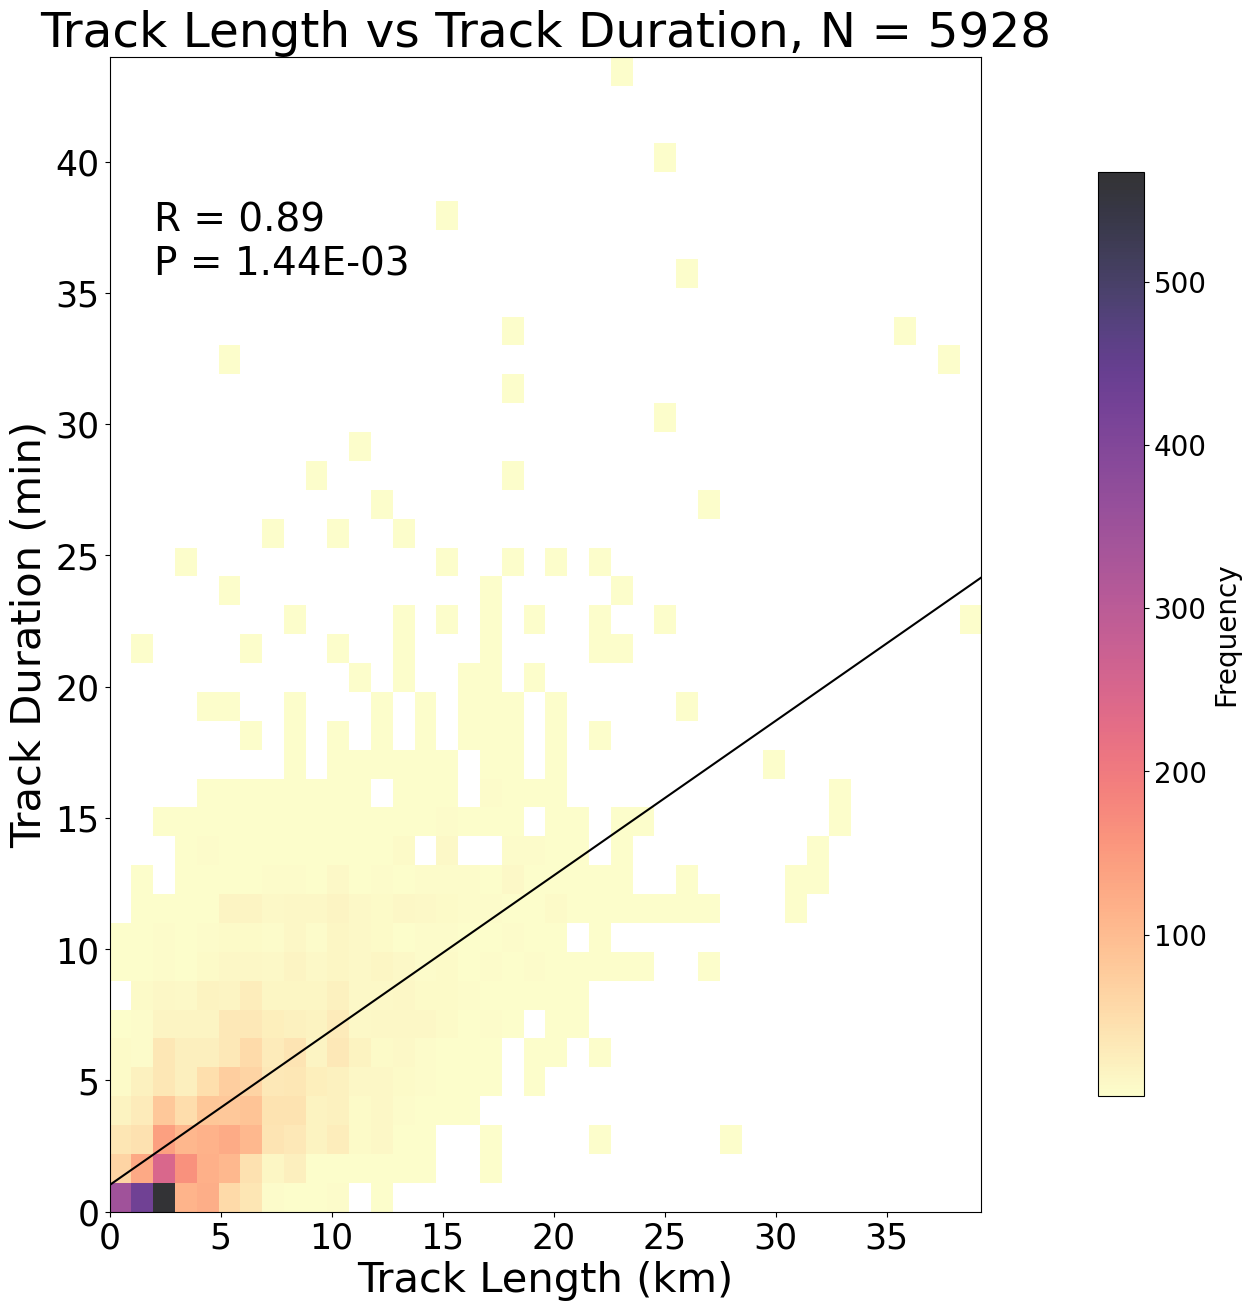

In [16]:
#Create a 2D histogram of distance vs duration
otd_r_model = scipy.stats.linregress(len_binned_len, dur_binned_len)
r_otd = otd_r_model.rvalue
p_otd = otd_r_model.pvalue
x2 = np.linspace(min(dist_km), max(dist_km), 100)
y3 = otd_r_model.intercept + x2*otd_r_model.slope

len_all = len(dist_km)
fig, ax = plt.subplots(1,1,figsize = (15,15), dpi = 400)
c,x,y, im5 = ax.hist2d(dist_km, td_mins, bins = (40,40), cmap = 'magma_r', cmin = 1., cmax = 700., alpha = 0.8)
#ax.scatter(len_binned_len, dur_binned_len, color = 'black', s = 40, linewidths = bin_lengths_normed_length*10)
ax.text(2, 34, 'R = %0.2f\n'%r_otd + 'P = %0.2E\n'%p_otd, fontsize = 28, color = 'black')
ax.plot(x2, y3, '-k')
cb1 = plt.colorbar(im5,shrink=0.8, pad=0.1)
cb1.set_label('Frequency', fontsize = 20)
cb1.ax.tick_params(labelsize = 20)
plt.title('Track Length vs Track Duration, N = %0.0f'%len_all, fontsize = 35)
plt.xlabel('Track Length (km)', fontsize=30)
plt.ylabel('Track Duration (min)', fontsize=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize=25)

In [17]:
jan25_lapserate = grouped_ots.mean('lapse_rate').lapse_rate
jan25_n2calc = grouped_ots.mean('n2').n2
ota_25jan = grouped_ots.mean('area_polygon').area_polygon
otd_25jan = grouped_ots.mean('dz_lowest_85').dz_lowest_85
#btd = grouped_ots.mean('btd').btd
#w_max = grouped_ots.mean('w').w
mucape = grouped_ots.mean('mucape').mucape
#duration = grouped_ots.duration.nth(0)
filt_dict = {'ota_25jan':ota_25jan, 'otd_25jan':otd_25jan, 'jan25_lapserate':jan25_lapserate, 'jan25_n2calc':jan25_n2calc,
                'mucape':mucape, 'duration':td_mins}
filtered_df = pd.DataFrame(data=filt_dict)

In [18]:
#Calculate the uncertainty in OTA following Davis and Di Girolamo (1997)
a = 4
ota_uncert = (2*a) * np.sqrt((ota_25jan/a)-1)

ota_uncert = np.mean(ota_uncert)

ota_uncert

27.09270184913352

In [19]:
#Calculate the uncertainty in OTD 
dz_pv = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_pv'])/-8.5
dz_therm = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_pt'])/-8.5

dz_diff = dz_pv.values - dz_therm.values
mean_dz_diff = np.mean(dz_diff)

mean_dz_diff

0.06731078998632432

In [20]:
#Create the OTA bins
bins_ota = np.linspace(min(ota_25jan), max(ota_25jan), 10)
bins_otd = np.linspace(min(otd_25jan), max(otd_25jan), 10)
bins_lapse = np.linspace(min(jan25_lapserate), max(jan25_lapserate), 10)
bins_n2 = np.linspace(min(jan25_n2calc), max(jan25_n2calc), 10)
bins_duration = np.linspace(min(td_mins), max(td_mins),10)
label_otd = bins_otd[:-1]
label_ota = bins_ota[:-1]
label_lapse = bins_lapse[:-1]
label_n2 = bins_n2[:-1]
label_duration = bins_duration[:-1]
labels_ota = list(map(str, label_ota))
labels_otd = list(map(str, label_otd))
labels_lapse = list(map(str, label_lapse))
labels_n2 = list(map(str, label_n2))
labels_duration = list(map(str, label_duration))
filtered_df['ota_bins'] = pd.cut(filtered_df.ota_25jan, bins = bins_ota, labels = labels_ota, right=True, include_lowest=True)
filtered_df['otd_bins'] = pd.cut(filtered_df.otd_25jan, bins = bins_otd, labels = labels_otd, right=True, include_lowest=True)
filtered_df['lapse_bins'] = pd.cut(filtered_df.jan25_lapserate, bins = bins_lapse, labels = labels_lapse, right=True, include_lowest=True)
filtered_df['n2_bins'] = pd.cut(filtered_df.jan25_n2calc, bins = bins_n2, labels = labels_n2, right=True, include_lowest=True)
filtered_df['duration_bins'] = pd.cut(filtered_df.duration, bins = bins_duration, labels = labels_duration, right=True, include_lowest=True)

In [21]:
binned_by_ota = filtered_df.groupby('ota_bins')
ota_binned_ota = binned_by_ota.mean('ota_25jan').ota_25jan
ota_binned_ota_min = binned_by_ota.min('ota_25jan').ota_25jan
ota_binned_ota_max = binned_by_ota.max('ota_25jan').ota_25jan
otd_binned_ota = binned_by_ota.mean('ota_25jan').otd_25jan
otd_binned_ota_min = binned_by_ota.min('ota_25jan').otd_25jan
otd_binned_ota_max = binned_by_ota.max('ota_25jan').otd_25jan
lapse_binned_ota = binned_by_ota.mean('ota_25jan').jan25_lapserate
lapse_binned_ota_min = binned_by_ota.min('ota_25jan').jan25_lapserate
lapse_binned_ota_max = binned_by_ota.max('ota_25jan').jan25_lapserate
n2_binned_ota = binned_by_ota.mean('ota_25jan').jan25_n2calc
duration_binned_ota = binned_by_ota.mean('ota_25jan').duration
otd_y_err_down = otd_binned_ota - otd_binned_ota_min
otd_y_err_up = otd_binned_ota_max - otd_binned_ota

binned_by_otd = filtered_df.groupby('otd_bins')
ota_binned_otd = binned_by_otd.mean('otd_25jan').ota_25jan
otd_binned_otd = binned_by_otd.mean('otd_25jan').otd_25jan
lapse_binned_otd = binned_by_otd.mean('otd_25jan').jan25_lapserate
n2_binned_otd = binned_by_otd.mean('otd_25jan').jan25_n2calc
duration_binned_otd = binned_by_otd.mean('otd_25jan').duration

binned_by_duration = filtered_df.groupby('duration_bins')
ota_binned_duration = binned_by_duration.mean('duration').ota_25jan
ota_binned_duration_min = binned_by_duration.min('duration').ota_25jan
ota_binned_duration_max = binned_by_duration.max('duration').ota_25jan
otd_binned_duration = binned_by_duration.mean('duration').otd_25jan
otd_binned_duration_min = binned_by_duration.min('duration').otd_25jan
otd_binned_duration_max = binned_by_duration.max('duration').otd_25jan
lapse_binned_duration = binned_by_duration.mean('duration').jan25_lapserate
n2_binned_duration = binned_by_duration.mean('duration').jan25_n2calc
duration_binned_duration = binned_by_duration.mean('duration').duration

otd_y_err_down_dur = otd_binned_duration - otd_binned_duration_min
otd_y_err_up_dur = otd_binned_duration_max - otd_binned_duration
ota_y_err_down_dur = ota_binned_duration - ota_binned_duration_min
ota_y_err_up_dur = ota_binned_duration_max - ota_binned_duration

binned_by_lapse = filtered_df.groupby('lapse_bins')
ota_binned_lapse = binned_by_lapse.mean('jan25_lapserate').ota_25jan
otd_binned_lapse = binned_by_lapse.mean('jan25_lapserate').otd_25jan
lapse_binned_lapse = binned_by_lapse.mean('jan25_lapserate').jan25_lapserate
n2_binned_lapse = binned_by_lapse.mean('jan25_lapserate').jan25_n2calc
duration_binned_lapse = binned_by_lapse.mean('jan25_lapserate').duration

binned_by_n2 = filtered_df.groupby('n2_bins')
ota_binned_n2 = binned_by_n2.mean('jan25_n2calc').ota_25jan
otd_binned_n2 = binned_by_n2.mean('jan25_n2calc').otd_25jan
lapse_binned_n2 = binned_by_n2.mean('jan25_n2calc').jan25_lapserate
n2_binned_n2 = binned_by_n2.mean('jan25_n2calc').jan25_n2calc
duration_binned_n2 = binned_by_n2.mean('jan25_n2calc').duration

In [22]:
otd_y_err = [otd_y_err_down, otd_y_err_up]
otd_y_err_dur = [otd_y_err_down_dur, otd_y_err_up_dur]
ota_y_err_dur = [ota_y_err_down_dur, ota_y_err_up_dur]

In [23]:
bin_lengths_ota = binned_by_ota.size()
bin_lengths_normed_ota = bin_lengths_ota/max(bin_lengths_ota)
bin_lengths_ott = binned_by_duration.size()
bin_lengths_normed_ott = bin_lengths_ott/max(bin_lengths_ott)

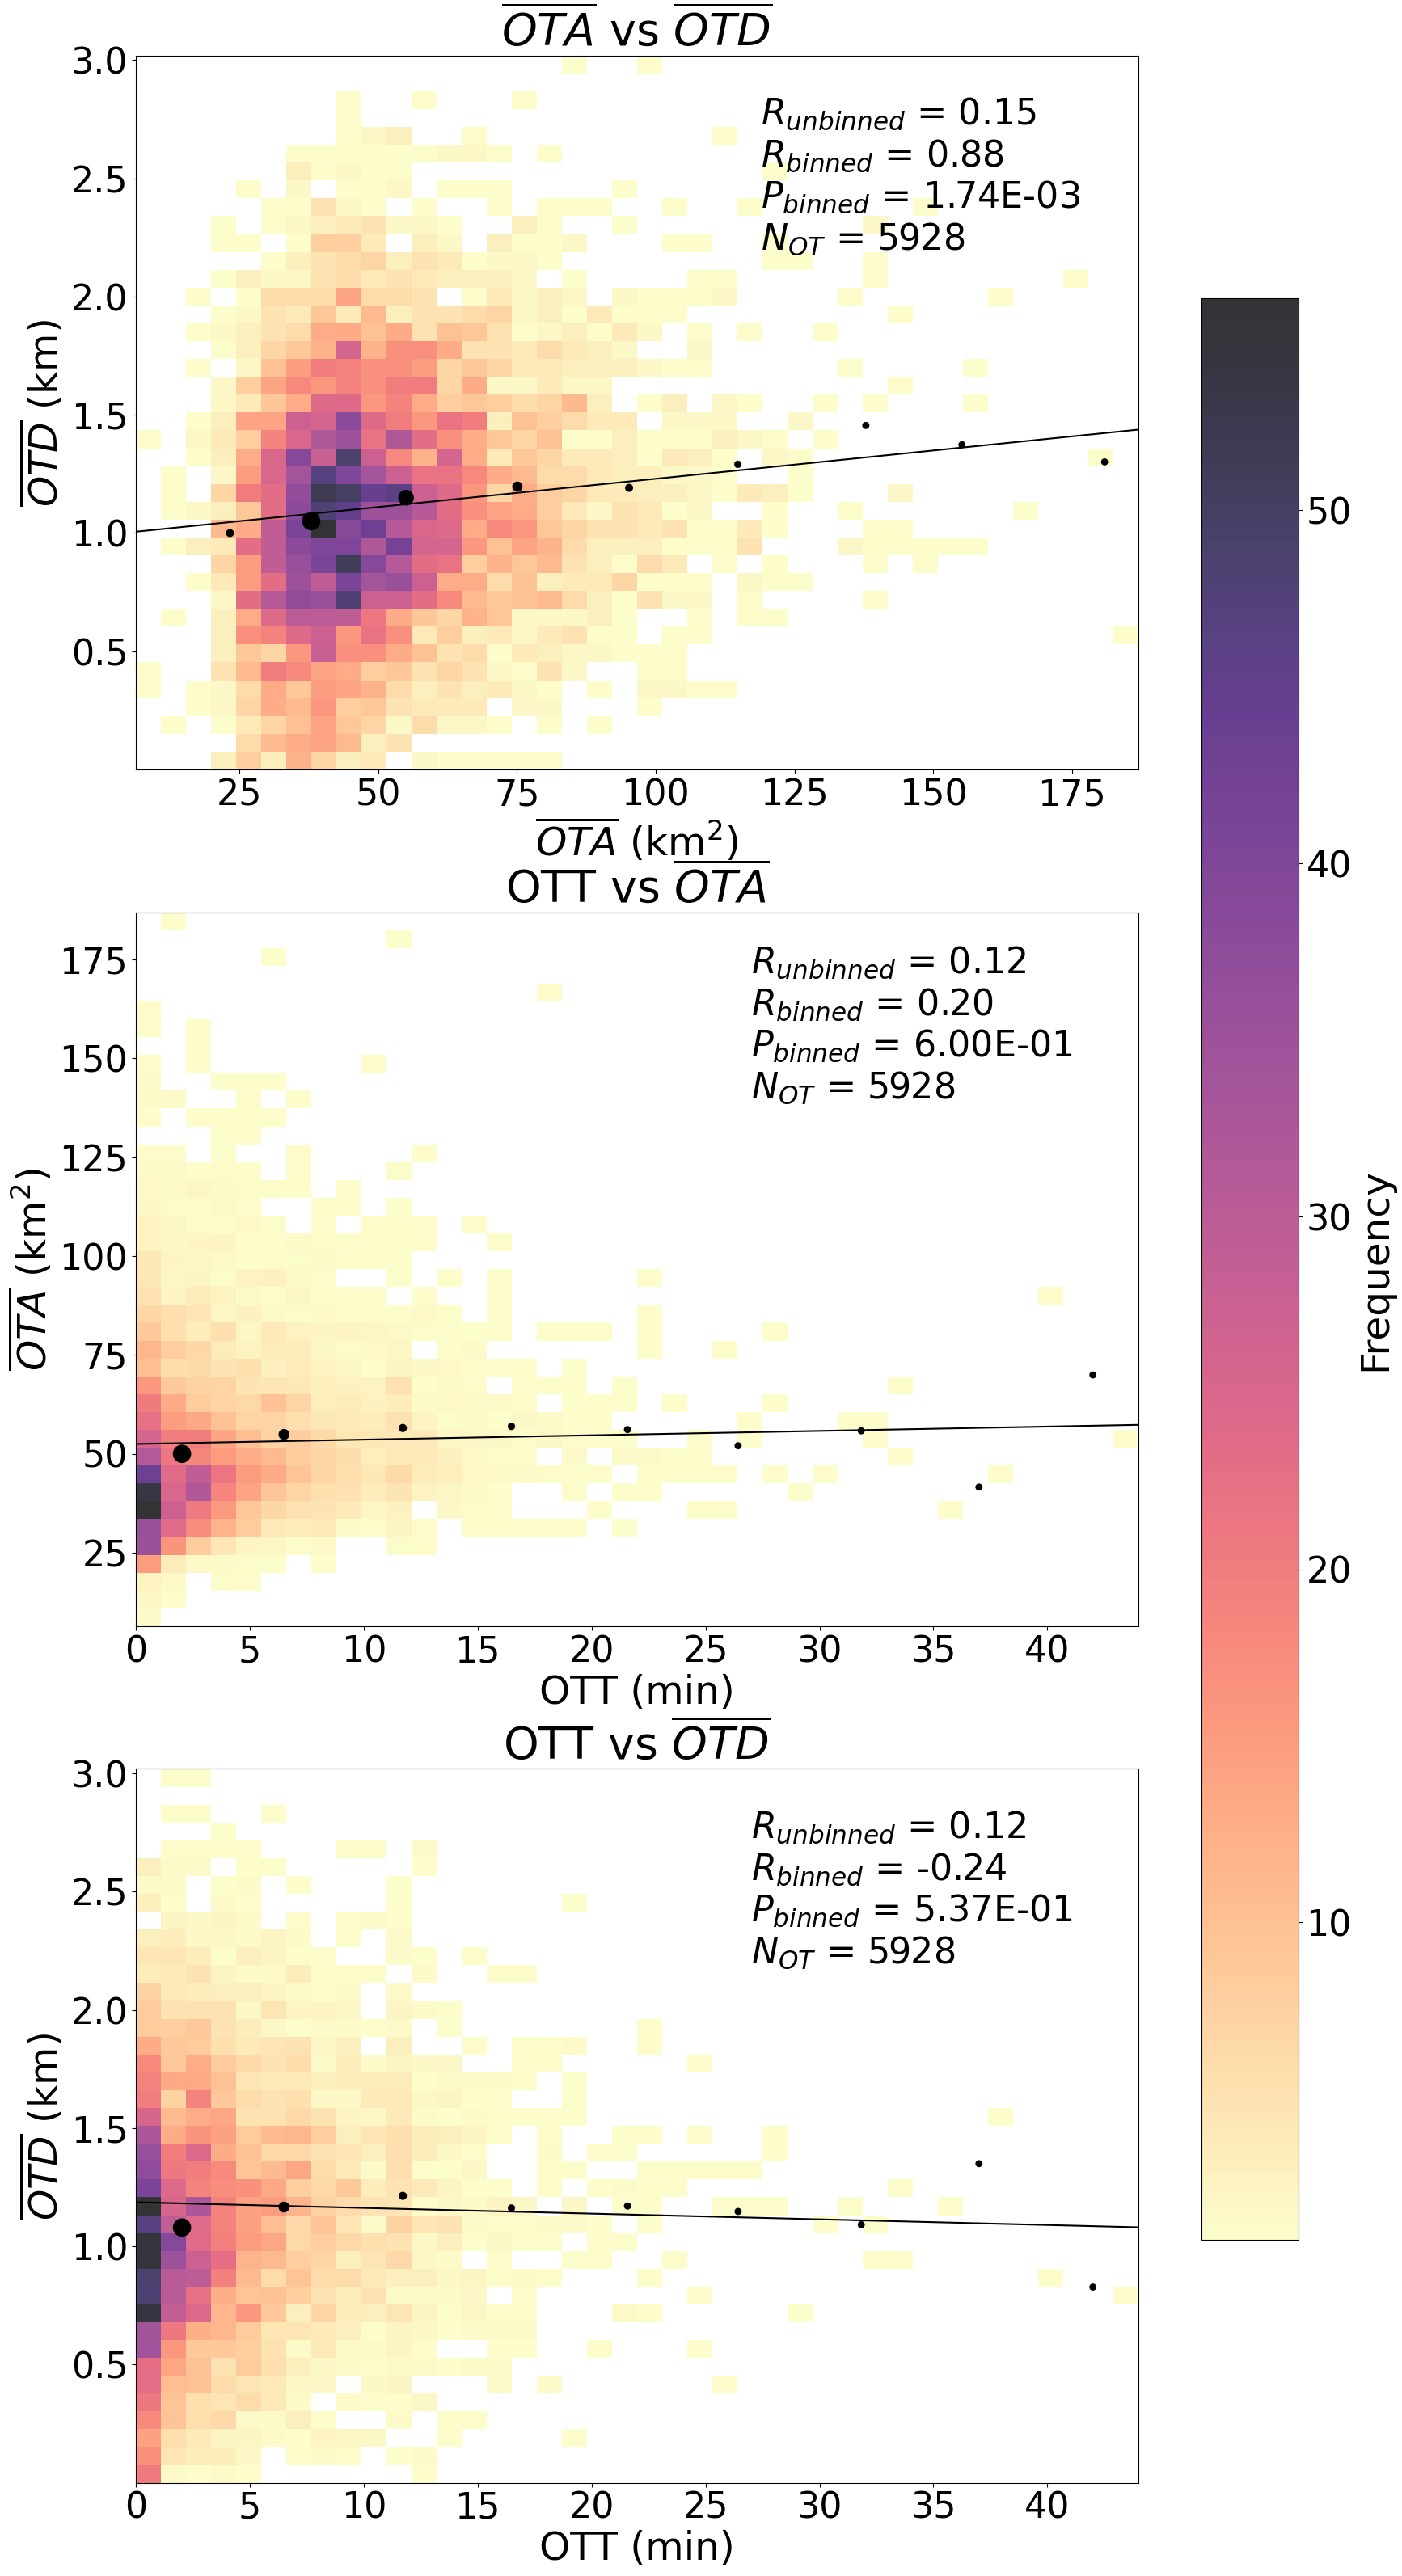

In [24]:
#Plot a scatter plot of the predicted vs actual top of the OT
fig, ax = plt.subplots(3,1,figsize=(20,39))
otd_r_model = scipy.stats.linregress(ota_binned_ota, otd_binned_ota)
otd_raw_model = scipy.stats.linregress(ota_25jan, otd_25jan)
r_otd_raw = otd_raw_model.rvalue
p_otd_raw = otd_raw_model.pvalue
r_otd = otd_r_model.rvalue
p_otd = otd_r_model.pvalue
x2 = np.linspace(min(ota_25jan), max(ota_25jan), 100)
y3 = otd_r_model.intercept + x2*otd_r_model.slope
samples = len(ota_25jan)
c,x,y, im1 = ax[0].hist2d(ota_25jan, otd_25jan, bins = (40,40), cmap = 'magma_r', cmin = 1., cmax = 400., alpha = 0.8)
ax[0].text(119, 2.2, '$R_{unbinned}$ = %0.2f\n'%r_otd_raw + '$R_{binned}$ = %0.2f\n'%r_otd + '$P_{binned}$ = %0.2E\n'%p_otd + '$N_{OT}$ = %0.0f'%samples, fontsize = 32, color = 'black')
ax[0].plot(x2, y3, '-k')
ax[0].set_title('$\overline{OTA}$ vs $\overline{OTD}$', fontsize = 40)
ax[0].set_xlabel('$\overline{OTA}$ (km$^{2}$)', fontsize= 35)
ax[0].set_ylabel('$\overline{OTD}$ (km)', fontsize = 35)
#plt.legend(loc='best', fontsize = 25)
ax[0].tick_params(axis='x', labelsize=32)
ax[0].tick_params(axis='y', labelsize=32)
#plt.scatter(ota_binned_ota, otd_binned_ota, color = 'black', s = bin_lengths_normed_ota* 1000)
#b = binned_by_ota.boxplot(column = 'otd_25jan', subplots=False, ax = ax)
#bx = b.xaxis
#x_label = bx.get_label()
#bx.set_visible(False)
ax[0].scatter(ota_binned_ota, otd_binned_ota, color = 'black', s = 40, linewidths = bin_lengths_normed_ota*10)
#ax[0].errorbar(ota_binned_ota, otd_binned_ota, yerr = otd_y_err, color = 'black', fmt = "o")

ota_r_model2 = scipy.stats.linregress(duration_binned_duration, ota_binned_duration)
r_ota2 = ota_r_model2.rvalue
p_ota2 = ota_r_model2.pvalue
otd2_raw_model = scipy.stats.linregress(td_mins, ota_25jan)
r_otd2_raw = otd2_raw_model.rvalue
p_otd2_raw = otd2_raw_model.pvalue
x5 = np.linspace(min(td_mins), max(td_mins), 100)
y5 = ota_r_model2.intercept + (x5*ota_r_model2.slope)
ax[1].hist2d(td_mins, ota_25jan, bins = (40,40), cmap = 'magma_r', cmin=1., cmax=400., alpha = 0.8)
ax[1].text(27, 140, '$R_{unbinned}$ = %0.2f\n'%r_otd2_raw + '$R_{binned}$ = %0.2f\n'%r_ota2 + '$P_{binned}$ = %0.2E\n'%p_ota2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 32, color = 'black')
ax[1].plot(x5, y5, '-k')
ax[1].set_title('OTT vs $\overline{OTA}$', fontsize = 40)
ax[1].set_xlabel('OTT (min)', fontsize = 35)
ax[1].set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 35)
#axes[0,0].legend( loc = 'best', fontsize = 10)
ax[1].tick_params(axis='x', labelsize=32)
ax[1].tick_params(axis='y', labelsize=32)
ax[1].scatter(duration_binned_duration, ota_binned_duration, color = 'black', s = 40, linewidths = bin_lengths_normed_ott*10)
#ax[1].errorbar(duration_binned_duration, ota_binned_duration, yerr = ota_y_err_dur, color = 'black', fmt = "o")

otd_r_model2 = scipy.stats.linregress(duration_binned_duration, otd_binned_duration)
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
otd3_raw_model = scipy.stats.linregress(td_mins, otd_25jan)
r_otd3_raw = otd3_raw_model.rvalue
p_otd3_raw = otd3_raw_model.pvalue
y6 = otd_r_model2.intercept + (x5*otd_r_model2.slope)
ax[2].hist2d(td_mins, otd_25jan, bins=(40,40), cmap = 'magma_r', cmin=1., cmax=400., alpha = 0.8)
ax[2].text(27, 2.2, '$R_{unbinned}$ = %0.2f\n'%r_otd2_raw + '$R_{binned}$ = %0.2f\n'%r_otd2 + '$P_{binned}$ = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 32, color = 'black')
ax[2].set_title('OTT vs $\overline{OTD}$', fontsize = 40)
ax[2].plot(x5, y6, '-k')
ax[2].set_xlabel('OTT (min)', fontsize = 35)
ax[2].set_ylabel('$\overline{OTD}$ (km)', fontsize = 35)
#axes[0,1].legend(loc = 'best', fontsize = 10)
ax[2].tick_params(axis='x', labelsize=32)
ax[2].tick_params(axis='y', labelsize=32)
ax[2].scatter(duration_binned_duration, otd_binned_duration, color = 'black', s = 40, linewidths = bin_lengths_normed_ott*10)
#ax[2].errorbar(duration_binned_duration, otd_binned_duration, yerr = otd_y_err_dur, color = 'black', fmt = "o")
cbar = fig.colorbar(im1, ax=ax, shrink=0.8)
cbar.set_label('Frequency', fontsize = 35)
cbar.ax.tick_params(labelsize = 32)

#plt.savefig('threepanel_9_lapse.png')


In [25]:
bin_lengths_lapse = binned_by_lapse.size()
bin_lengths_normed_lapse = bin_lengths_lapse/max(bin_lengths_lapse)
bin_lengths_n2 = binned_by_n2.size()
bin_lengths_normed_n2 = bin_lengths_n2/max(bin_lengths_n2)

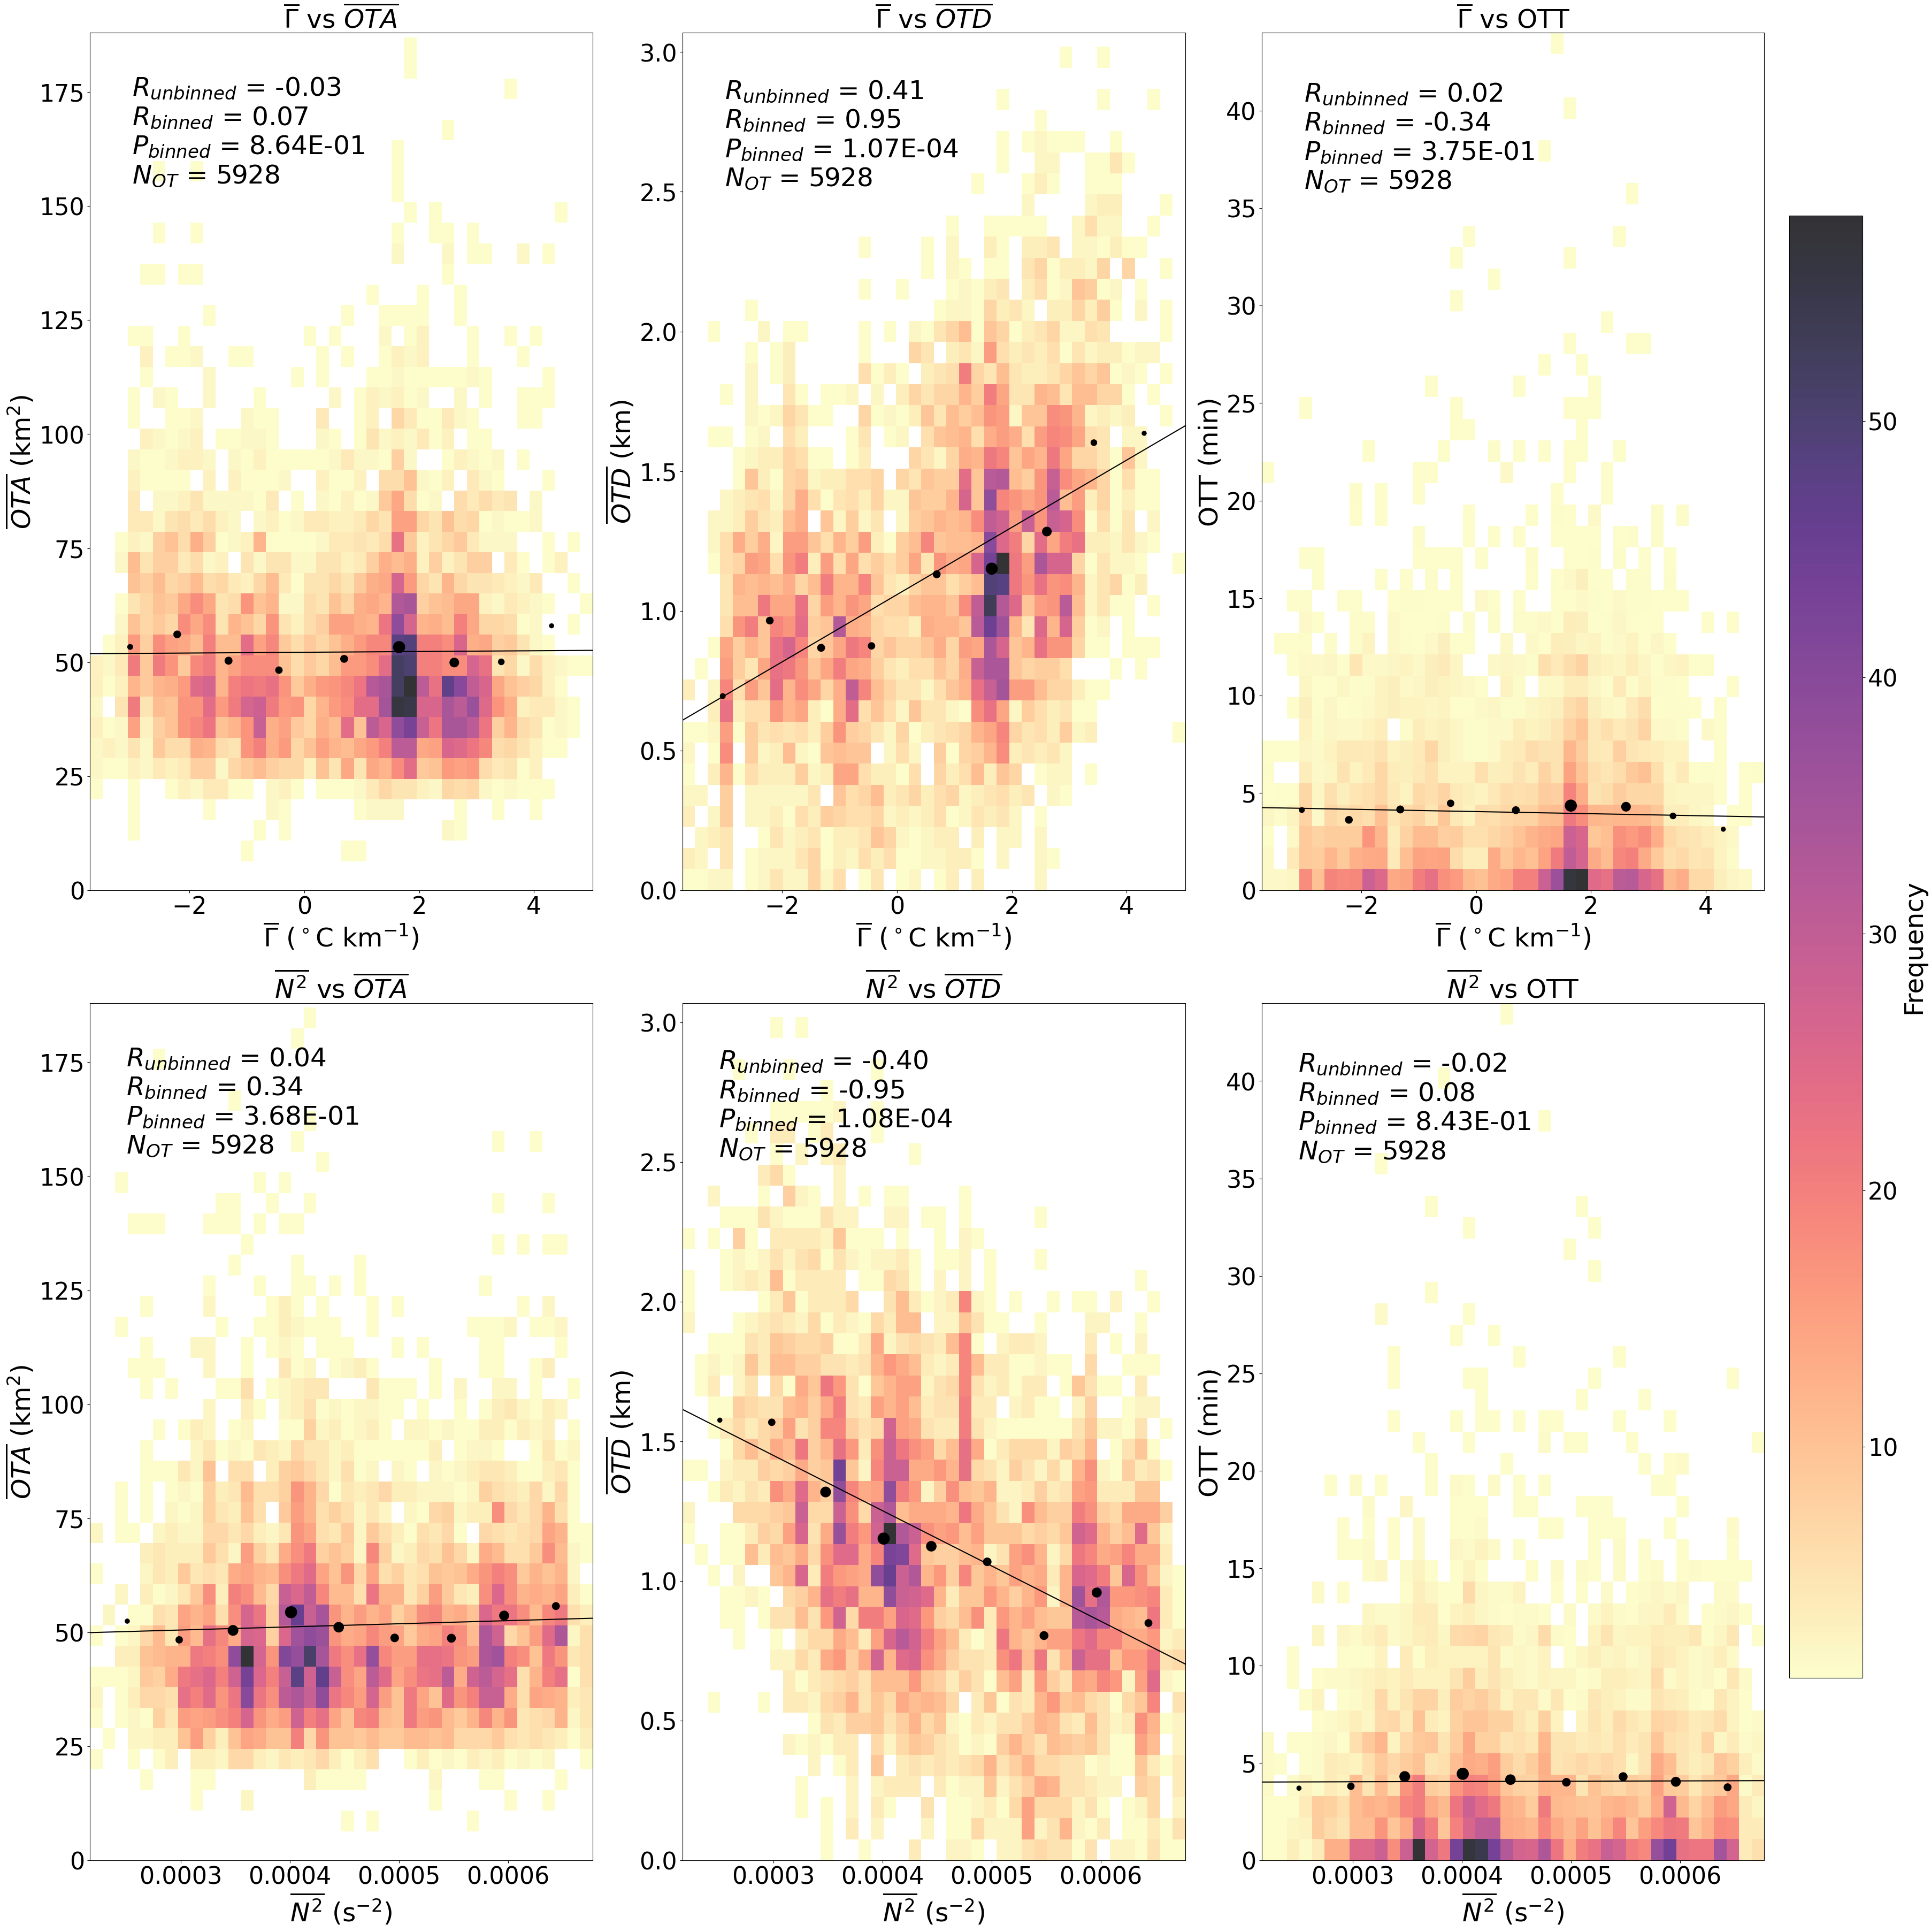

In [26]:
fig1, axes = plt.subplots(2,3,figsize=(36,36), constrained_layout=True)
samples = len(ota_25jan)
ota_r_model = scipy.stats.linregress(lapse_binned_lapse, ota_binned_lapse)
ota_r_umodel = scipy.stats.linregress(jan25_lapserate, ota_25jan)
r_ota_ubin = ota_r_umodel.rvalue
p_ota_ubin = ota_r_model.pvalue
r_ota = ota_r_model.rvalue
p_ota = ota_r_model.pvalue 
x5 = np.linspace(min(jan25_lapserate), max(jan25_lapserate), 100, endpoint=True)
y5 = ota_r_model.intercept + (x5 * ota_r_model.slope)
c,x,y, im1 = axes[0,0].hist2d(jan25_lapserate, ota_25jan, bins = (40,40), cmap = 'magma_r', cmin=1., cmax= 400., alpha = 0.8)
axes[0,0].text(-3, 155, '$R_{unbinned}$ = %0.2f\n'%r_ota_ubin + '$R_{binned}$ = %0.2f\n'%r_ota + '$P_{binned}$ = %0.2E\n'%p_ota +\
     '$N_{OT}$ = %0.0f'%samples, fontsize = 35, color = 'black')
axes[0,0].plot(x5, y5, '-k')
axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
axes[0,0].set_title('$\overline{\Gamma}$ vs $\overline{OTA}$', fontsize = 35)
axes[0,0].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 35)
axes[0,0].set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 35)
axes[0,0].set_ylim(0, max(ota_25jan)+1)
#axes[0,0].legend( loc = 'best', fontsize = 10)
axes[0,0].tick_params(axis='x', labelsize=32)
axes[0,0].tick_params(axis='y', labelsize=32)

otd_r_model2 = scipy.stats.linregress(lapse_binned_lapse, otd_binned_lapse)
otd_r_model_ubin = scipy.stats.linregress(jan25_lapserate, otd_25jan)
r_otd_ubin = otd_r_model_ubin.rvalue
p_otd_ubin = otd_r_model_ubin.pvalue
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
#print([r_otd, p_otd])
y6 = otd_r_model2.intercept + (x5 * otd_r_model2.slope)
axes[0,1].hist2d(jan25_lapserate, otd_25jan, bins=(40,40), cmap = 'magma_r', cmin = 1., cmax= 400., alpha = 0.8)
axes[0,1].text(-3, 2.52,'$R_{unbinned}$ = %0.2f\n'%r_otd_ubin + '$R_{binned}$ = %0.2f\n'%r_otd2 + '$P_{binned}$ = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%samples,\
     fontsize = 35, color = 'black')
axes[0,1].scatter(lapse_binned_lapse, otd_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
axes[0,1].set_title('$\overline{\Gamma}$ vs $\overline{OTD}$', fontsize = 35)
axes[0,1].plot(x5, y6, '-k')
axes[0,1].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 35)
axes[0,1].set_ylabel('$\overline{OTD}$ (km)', fontsize = 35)
axes[0,1].set_ylim(0, max(otd_25jan)+0.05)
axes[0,1].tick_params(axis='x', labelsize=32)
axes[0,1].tick_params(axis='y', labelsize=32)


ota_r_model3 = scipy.stats.linregress(n2_binned_n2, ota_binned_n2)
ota_r_model_ubin2 = scipy.stats.linregress(jan25_n2calc, ota_25jan)
r_ota_ubin2 = ota_r_model_ubin2.rvalue
p_ota_ubin2 = ota_r_model_ubin2.pvalue
r_ota3 = ota_r_model3.rvalue
p_ota3 = ota_r_model3.pvalue
x = np.linspace(min(jan25_n2calc), max(jan25_n2calc), 100, endpoint=True)
y = ota_r_model3.intercept + (x*ota_r_model3.slope)
axes[1,0].hist2d(jan25_n2calc, ota_25jan, bins=(40,40), cmap='magma_r', cmin=1., cmax= 400., alpha = 0.8)
axes[1,0].text(0.00025, 155, '$R_{unbinned}$ = %0.2f\n'%r_ota_ubin2 + '$R_{binned}$ = %0.2f\n'%r_ota3 + '$P_{binned}$ = %0.2E\n'%p_ota3 + '$N_{OT}$ = %0.0f'%samples, \
     fontsize = 35, color = 'black')
axes[1,0].scatter(n2_binned_n2, ota_binned_n2, color='black', s = 40, linewidths = bin_lengths_normed_n2*10)
axes[1,0].plot(x,y, '-k')
axes[1,0].set_title('$\overline{N^{2}}$ vs $\overline{OTA}$', fontsize = 35)
axes[1,0].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 35)
axes[1,0].set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 35)
axes[1,0].set_ylim(0, max(ota_25jan)+1)
#axes[1,0].legend( loc = 'best', fontsize = 10)
axes[1,0].tick_params(axis='x', labelsize=32)
axes[1,0].tick_params(axis='y', labelsize=32)

otd_r_model4 = scipy.stats.linregress(n2_binned_n2, otd_binned_n2)
otd_r_model_ubin2 = scipy.stats.linregress(jan25_n2calc, otd_25jan)
r_otd_ubin2 = otd_r_model_ubin2.rvalue
p_otd_ubin2 = otd_r_model_ubin2.pvalue
r_otd4 = otd_r_model4.rvalue
p_otd4 = otd_r_model4.pvalue

y7 = otd_r_model4.intercept + (otd_r_model4.slope*x)
axes[1,1].hist2d(jan25_n2calc, otd_25jan, bins=(40,40), cmap = 'magma_r', cmin=1., cmax= 400., alpha = 0.8)
axes[1,1].text(0.00025, 2.52, '$R_{unbinned}$ = %0.2f\n'%r_otd_ubin2 + '$R_{binned}$ = %0.2f\n'%r_otd4 + '$P_{binned}$ = %0.2E\n'%p_otd4 + '$N_{OT}$ = %0.0f'%samples, \
     fontsize = 35, color = 'black')
axes[1,1].scatter(n2_binned_n2, otd_binned_n2, color='black', s = 40, linewidths = bin_lengths_normed_n2*10)
axes[1,1].set_title('$\overline{N^{2}}$ vs $\overline{OTD}$', fontsize = 35)
axes[1,1].plot(x,y7, '-k'), 
#axes[1,1].set_xtick(fontsize = 12, angle = 45)
axes[1,1].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 35)
axes[1,1].set_ylabel('$\overline{OTD}$ (km)', fontsize = 35)
axes[1,1].set_ylim(0, max(otd_25jan)+0.05)
#axes[1,1].legend(loc = 'best', fontsize = 20)
axes[1,1].tick_params(axis='x', labelsize=32)
axes[1,1].tick_params(axis='y', labelsize=32)

ota_r_model5 = scipy.stats.linregress(lapse_binned_lapse, duration_binned_lapse)
ott_r_model_ubin = scipy.stats.linregress(jan25_lapserate, td_mins)
r_ott_ubin = ott_r_model_ubin.rvalue
p_ott_ubin = ott_r_model_ubin.pvalue
r_ota5 = ota_r_model5.rvalue
p_ota5 = ota_r_model5.pvalue
y8 = ota_r_model5.intercept + (ota_r_model5.slope*x5)
axes[0,2].hist2d(jan25_lapserate, td_mins, bins = (40,40), cmap = 'magma_r', cmin=1., cmax= 400., alpha = 0.8)
axes[0,2].text(-3, 36, '$R_{unbinned}$ = %0.2f\n'%r_ott_ubin +'$R_{binned}$ = %0.2f\n'%r_ota5 + '$P_{binned}$ = %0.2E\n'%p_ota5 + '$N_{OT}$ = %0.0f'%samples,\
      fontsize = 35, color = 'black')
axes[0,2].scatter(lapse_binned_lapse, duration_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
axes[0,2].plot(x5, y8, '-k')
axes[0,2].set_title('$\overline{\Gamma}$ vs OTT', fontsize = 35)
axes[0,2].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 35)
axes[0,2].set_ylabel('OTT (min)', fontsize = 35)
axes[0,2].set_ylim(0, max(td_mins))
#axes[0,0].legend( loc = 'best', fontsize = 10)
axes[0,2].tick_params(axis='x', labelsize=32)
axes[0,2].tick_params(axis='y', labelsize=32)

otd_r_model6 = scipy.stats.linregress(n2_binned_n2, duration_binned_n2)
ott_r_model_ubin2 = scipy.stats.linregress(jan25_n2calc, td_mins)
r_ott_ubin2 = ott_r_model_ubin2.rvalue
p_ott_ubin2 = ott_r_model_ubin2.pvalue
r_otd6 = otd_r_model6.rvalue
p_otd6 = otd_r_model6.pvalue
#print([r_otd, p_otd])
y9 = otd_r_model6.intercept + (x*otd_r_model6.slope)
axes[1,2].hist2d(jan25_n2calc, td_mins, bins=(40,40), cmap = 'magma_r', cmin=1., cmax= 400., alpha = 0.8)
axes[1,2].text(0.00025, 36, '$R_{unbinned}$ = %0.2f\n'%r_ott_ubin2 +'$R_{binned}$ = %0.2f\n'%r_otd6 + '$P_{binned}$ = %0.2E\n'%p_otd6 + '$N_{OT}$ = %0.0f'%samples,\
      fontsize = 35, color = 'black')
axes[1,2].scatter(n2_binned_n2, duration_binned_n2, color='black', s = 40, linewidths = bin_lengths_normed_n2*10)
axes[1,2].set_title('$\overline{N^{2}}$ vs OTT', fontsize = 35)
axes[1,2].plot(x, y9, '-k')
axes[1,2].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 35)
axes[1,2].set_ylabel('OTT (min)', fontsize = 35)
axes[1,2].set_ylim(0, max(td_mins))
#axes[0,1].legend(loc = 'best', fontsize = 10)
axes[1,2].tick_params(axis='x', labelsize=32)
axes[1,2].tick_params(axis='y', labelsize=32)
cbar = fig1.colorbar(im1, ax=axes[:, 2], shrink=0.8)
cbar.set_label('Frequency', fontsize = 35)
cbar.ax.tick_params(labelsize = 32)
#plt.suptitle('Mean Statistics', fontsize = 35)
#plt.savefig('./four_panel_mean_07.png')
#plt.savefig('sixpanel_9_lapse.png')

In [27]:
#Create the OTA bins
bins_cape = np.linspace(min(mucape), max(mucape), 10)
label_cape = bins_cape[:-1]
labels_cape = list(map(str, label_cape))
filtered_df['cape_bins'] = pd.cut(filtered_df.mucape, bins = bins_cape, labels = labels_cape, right=True, include_lowest=True)

In [28]:
upper_cape = filtered_df[filtered_df.mucape > 617]
bins_upper_cape = np.linspace(min(upper_cape.mucape), max(upper_cape.mucape), 10)
label_upper_cape = bins_upper_cape[:-1]
labels_upper_cape = list(map(str, label_upper_cape))
upper_cape['upper_cape_bins'] = pd.cut(upper_cape.mucape, bins = bins_upper_cape, labels = labels_upper_cape, right=True, include_lowest=True)

In [29]:
binned_by_cape = filtered_df.groupby('cape_bins')
mean_cape_binned = binned_by_cape.mean('mucape').mucape
mean_ota_cape = binned_by_cape.mean('mucape').ota_25jan
mean_otd_cape = binned_by_cape.mean('mucape').otd_25jan
mean_ott_cape = binned_by_cape.mean('mucape').duration

bin_lengths_cape = binned_by_cape.size()
bin_lengths_normed_cape = bin_lengths_cape/max(bin_lengths_cape)

binned_by_upper_cape = upper_cape.groupby('upper_cape_bins')
mean_cape_upper_binned = binned_by_upper_cape.mean('mucape').mucape
mean_otd_upper_cape = binned_by_upper_cape.mean('mucape').otd_25jan
bin_lengths_upper_cape = binned_by_upper_cape.size()
bin_lengths_normed_upper_cape = bin_lengths_upper_cape/max(bin_lengths_upper_cape)

0.26205082850231487 0.49576776444367365


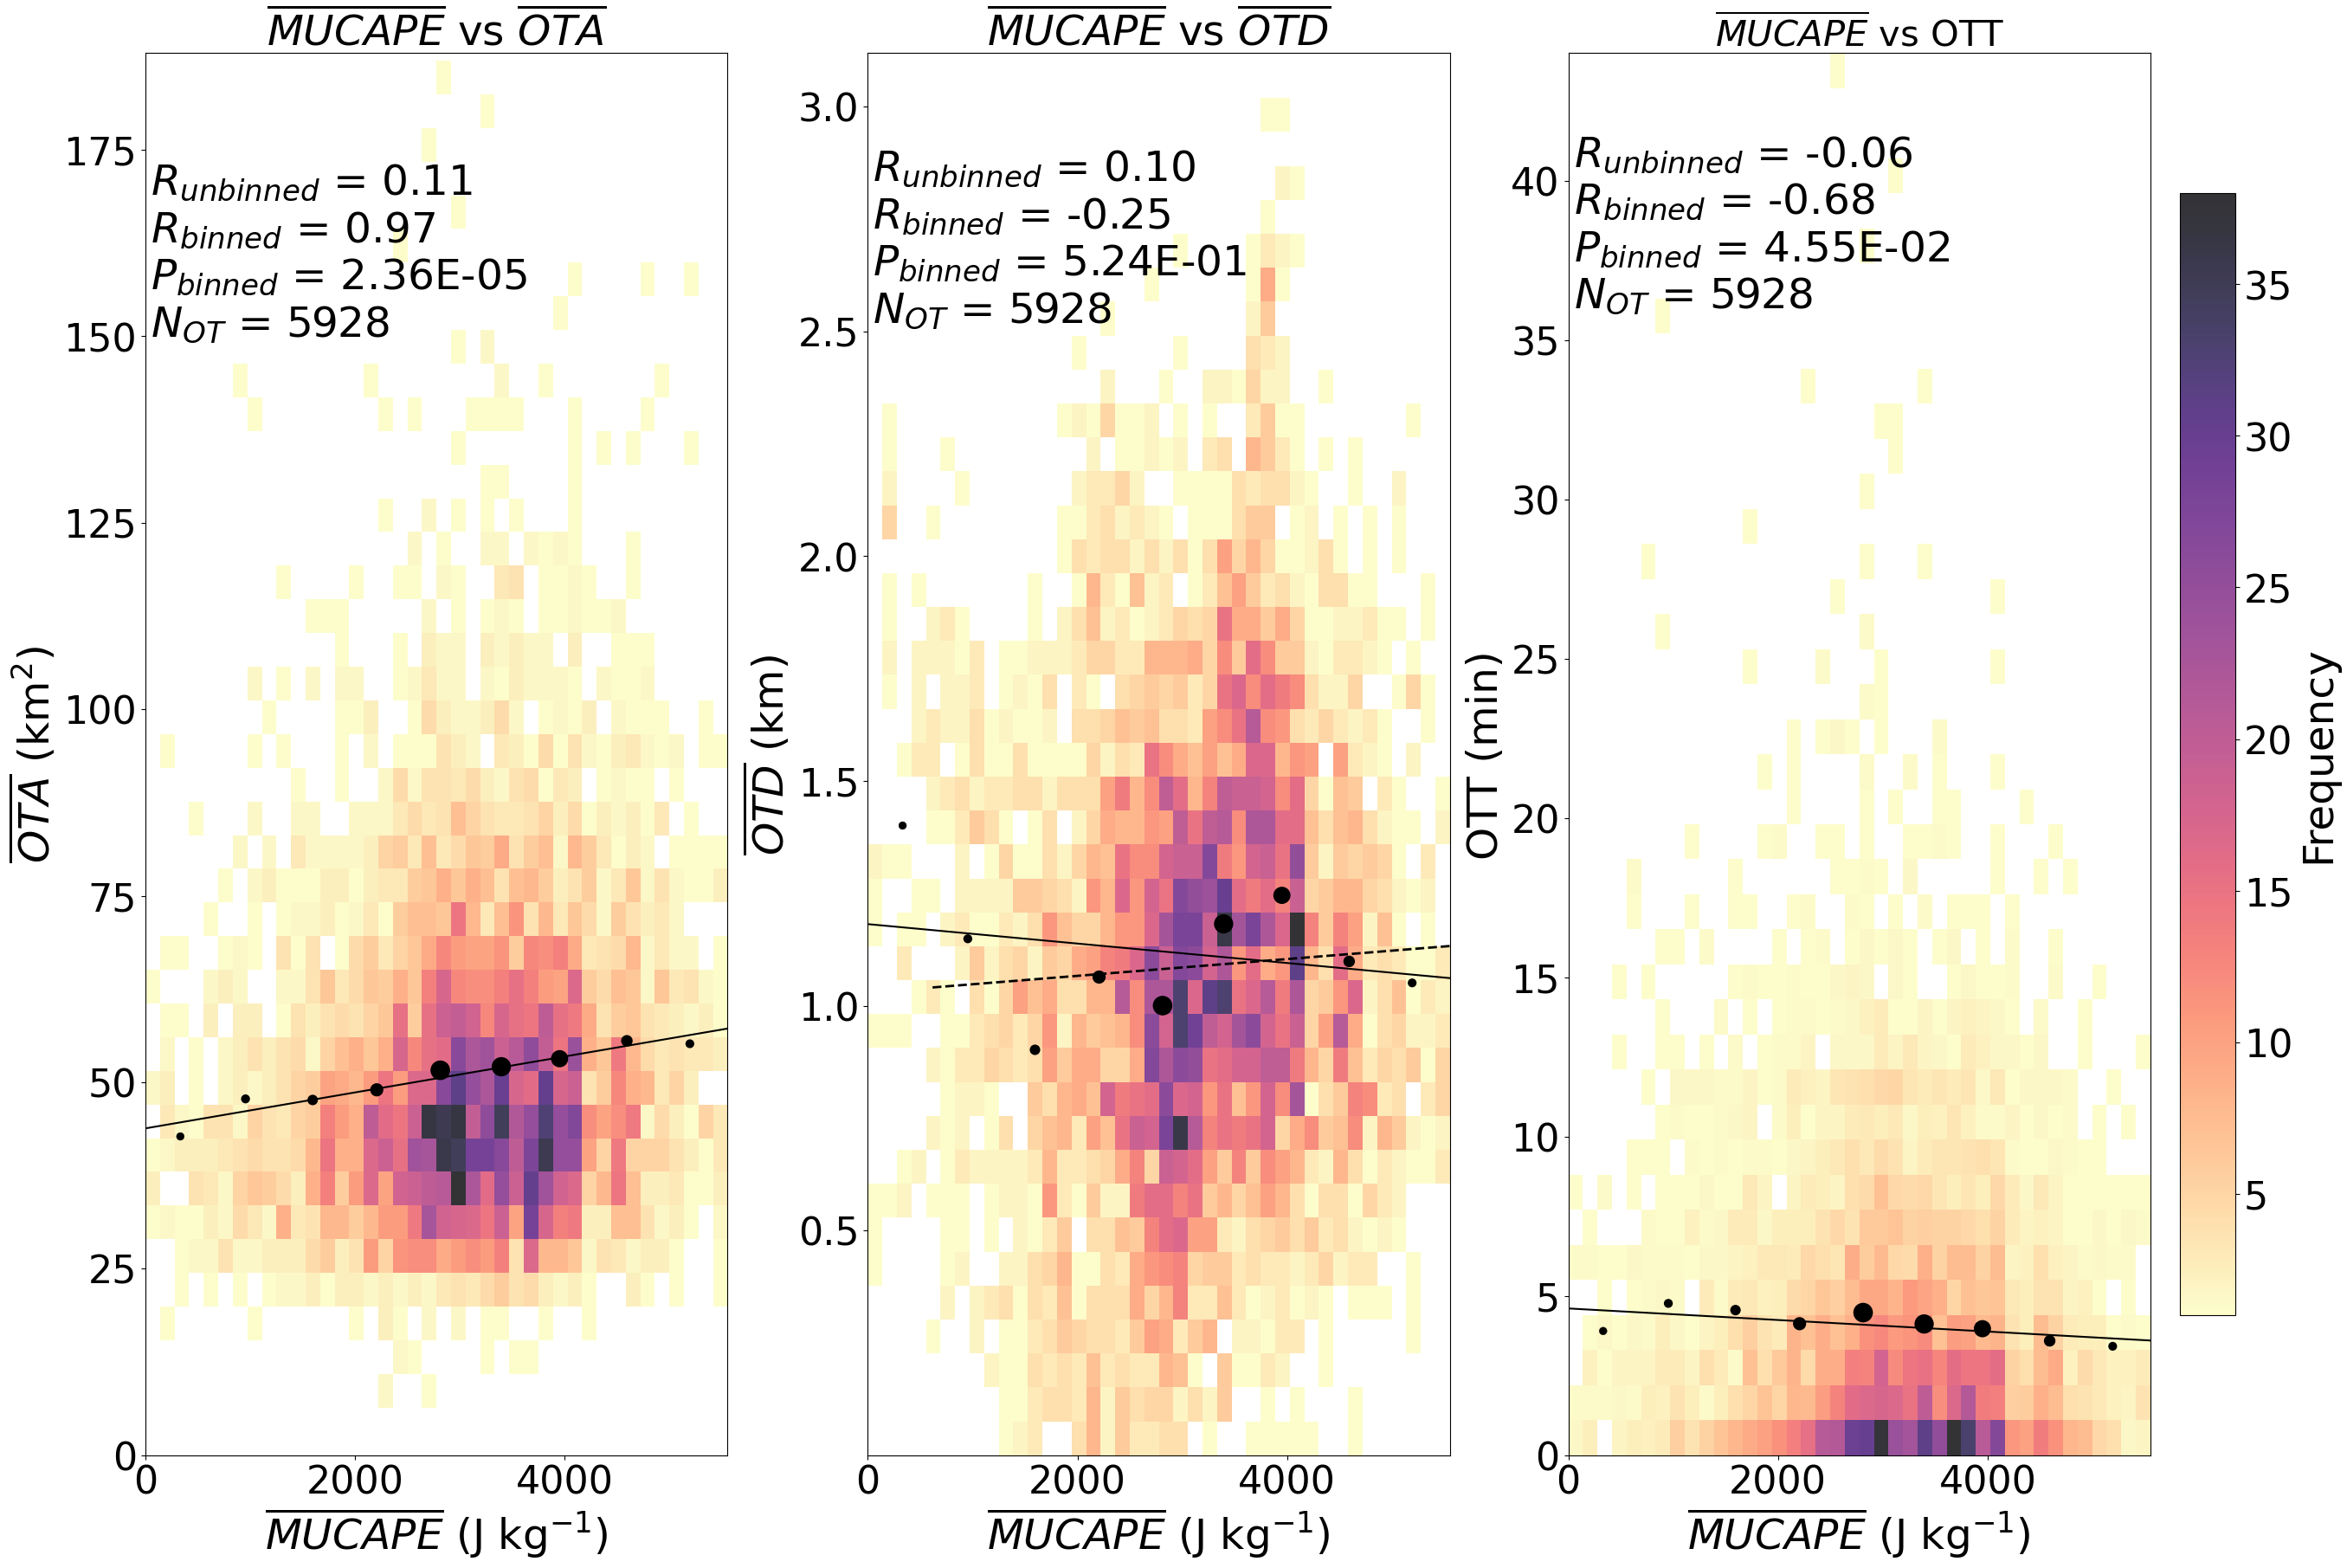

In [30]:
#Plot OTA and OTD as a function of CAPE
fig1, axes = plt.subplots(1,3,figsize=(27, 18), constrained_layout=True)
samples = len(ota_25jan)

ota_r_model = scipy.stats.linregress(mean_cape_binned, mean_ota_cape)
ota_cape_model = scipy.stats.linregress(mucape, ota_25jan)
r_cape_ota = ota_cape_model.rvalue
p_cape_ota = ota_cape_model.pvalue
r_ota = ota_r_model.rvalue
p_ota = ota_r_model.pvalue
x2 = np.linspace(min(mucape), max(mucape),100)
y2 = ota_r_model.intercept + x2*ota_r_model.slope
#print([r_ota, p_ota])

c,x,y, im1 = axes[0].hist2d(mucape, ota_25jan, bins = (40,40), cmap = 'magma_r', cmin=1., cmax=400., alpha = 0.8)
axes[0].text(50, 150, '$R_{unbinned}$ = %0.2f\n'%r_cape_ota + '$R_{binned}$ = %0.2f\n'%r_ota + '$P_{binned}$ = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, \
    fontsize = 35, color = 'black')
axes[0].scatter(mean_cape_binned, mean_ota_cape, color='black',  s = 40, linewidths = bin_lengths_normed_cape*10)
#axes[0].scatter(mean_cape_binned, mean_ota_cape, color = 'black', s = bin_lengths_normed_cape* 1000)
axes[0].plot(x2, y2, '-k')
axes[0].set_title('$\overline{MUCAPE}$ vs $\overline{OTA}$', fontsize = 35)
axes[0].set_xlabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 35)
axes[0].set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 35)
axes[0].set_ylim(0, max(ota_25jan)+1)
#axes[0].legend( loc = 'best', fontsize = 10)
axes[0].tick_params(axis='x', labelsize=32)
axes[0].tick_params(axis='y', labelsize=32)

otd_r_model = scipy.stats.linregress(mean_cape_binned, mean_otd_cape)
otd_cape_model = scipy.stats.linregress(mucape, otd_25jan)
r_cape_otd = otd_cape_model.rvalue
p_cape_otd = otd_cape_model.pvalue
r_otd = otd_r_model.rvalue
p_otd = otd_r_model.pvalue
y3 = otd_r_model.intercept + x2*otd_r_model.slope
otd_upper_model = scipy.stats.linregress(mean_cape_upper_binned, mean_otd_upper_cape)
r_upper = otd_upper_model.rvalue
p_upper = otd_upper_model.pvalue
x_upper = np.linspace(min(upper_cape.mucape), max(upper_cape.mucape), 100)
print(r_upper, p_upper)
y_upper = otd_upper_model.intercept + x_upper*otd_upper_model.slope
#print([r_otd, p_otd])
c,x,y, im1 = axes[1].hist2d(mucape, otd_25jan, bins = (40,40), cmap = 'magma_r', cmin=1., cmax=400., alpha = 0.8)
axes[1].text(50, 2.52, '$R_{unbinned}$ = %0.2f\n'%r_cape_otd + '$R_{binned}$ = %0.2f\n'%r_otd + '$P_{binned}$ = %0.2E\n'%p_otd + '$N_{OT}$ = %0.0f'%samples,\
     fontsize = 35, color = 'black')
axes[1].scatter(mean_cape_binned, mean_otd_cape, color='black', s = 40, linewidths = bin_lengths_normed_cape*10)
#axes[1].scatter(mean_cape_binned, mean_otd_cape, color = 'black', s = bin_lengths_normed_cape*1000)
axes[1].set_title('$\overline{MUCAPE}$ vs $\overline{OTD}$', fontsize = 35)
axes[1].plot(x2, y3, '-k')
axes[1].plot(x_upper, y_upper, '--k', lw = 2)
axes[1].set_xlabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 35)
axes[1].set_ylabel('$\overline{OTD}$ (km)', fontsize = 35)
axes[1].set_ylim(min(otd_25jan), max(otd_25jan)+0.1)
#axes[1].legend(loc = 'best', fontsize = 20)
axes[1].tick_params(axis='x', labelsize=32)
axes[1].tick_params(axis='y', labelsize=32)
cbar = fig1.colorbar(im1, ax=axes[2], shrink=0.8)
cbar.set_label('Frequency', fontsize = 35)
cbar.ax.tick_params(labelsize = 32)
#plt.suptitle('Mean Statistics', fontsize = 35)
#plt.savefig('./mucape_mean_07.png')

otd_r_model2 = scipy.stats.linregress(mean_cape_binned, mean_ott_cape)
ott_cape_model = scipy.stats.linregress(mucape, td_mins)
r_cape_ott = ott_cape_model.rvalue
p_cape_ott = ott_cape_model.pvalue
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
y4 = otd_r_model2.intercept + x2*otd_r_model2.slope
#print([r_otd, p_otd])
c,x,y, im1 = axes[2].hist2d(mucape, td_mins, bins = (40,40), cmap = 'magma_r', cmin=1., cmax=400., alpha = 0.8)
axes[2].text(50, 36, '$R_{unbinned}$ = %0.2f\n'%r_cape_ott + '$R_{binned}$ = %0.2f\n'%r_otd2 + '$P_{binned}$ = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%len(mucape), \
    fontsize = 35, color = 'black')
axes[2].scatter(mean_cape_binned, mean_ott_cape, color='black', s = 40, linewidths = bin_lengths_normed_cape*10)
#axes[1].scatter(mean_cape_binned, mean_otd_cape, color = 'black', s = bin_lengths_normed_cape*1000)
axes[2].set_title('$\overline{MUCAPE}$ vs OTT', fontsize = 30)
axes[2].plot(x2, y4, '-k')
axes[2].set_xlabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 35)
axes[2].set_ylabel('OTT (min)', fontsize = 35)
axes[2].set_ylim(0, max(td_mins))
#axes[1].legend(loc = 'best', fontsize = 20)
axes[2].tick_params(axis='x', labelsize=32)
axes[2].tick_params(axis='y', labelsize=32)
#plt.savefig('./mucape_mean_07.png')
#plt.savefig('mucape_9_lapse.png')

In [31]:
#Calculate the mean value of each bin for the OT characteristics
from scipy.stats import binned_statistic_2d

ota_binned_lapse_mean = binned_statistic_2d(mucape, jan25_lapserate, ota_25jan, statistic = 'mean', bins = [40,40])
otd_binned_lapse_mean = binned_statistic_2d(mucape, jan25_lapserate, otd_25jan, statistic = 'mean', bins = [40,40])
ott_binned_lapse_mean = binned_statistic_2d(mucape, jan25_lapserate, td_mins, statistic = 'mean', bins = [40,40])

ota_binned_lapse_med = binned_statistic_2d(mucape, jan25_lapserate, ota_25jan, statistic = 'median', bins = [20,20])
otd_binned_lapse_med = binned_statistic_2d(mucape, jan25_lapserate, otd_25jan, statistic = 'median', bins = [20,20])
ott_binned_lapse_med = binned_statistic_2d(mucape, jan25_lapserate, td_mins, statistic = 'median', bins = [20,20])

ota_binned_n2_mean = binned_statistic_2d(mucape, jan25_n2calc, ota_25jan, statistic = 'mean', bins = [40,40])
otd_binned_n2_mean = binned_statistic_2d(mucape, jan25_n2calc, otd_25jan, statistic = 'mean', bins = [40,40])
ott_binned_n2_mean = binned_statistic_2d(mucape, jan25_n2calc, td_mins, statistic = 'mean', bins = [40,40])

ota_binned_n2_med = binned_statistic_2d(mucape, jan25_n2calc, ota_25jan, statistic = 'median', bins = [20,20])
otd_binned_n2_med = binned_statistic_2d(mucape, jan25_n2calc, otd_25jan, statistic = 'median', bins = [20,20])
ott_binned_n2_med = binned_statistic_2d(mucape, jan25_n2calc, td_mins, statistic = 'median', bins = [20,20])

In [32]:
cl, xbl, ybl = np.histogram2d(mucape, jan25_lapserate, bins = (20,20))
cn, xbn, ybn = np.histogram2d(mucape, jan25_n2calc, bins = (20,20))

ota_sum_lapse_mean, ta, tt = np.histogram2d(mucape, jan25_lapserate, weights = ota_25jan, bins = (xbl, ybl))
ota_sum_n2_mean, ta, tt = np.histogram2d(mucape, jan25_n2calc, weights = ota_25jan, bins = (xbn, ybn))

otd_sum_lapse_mean, ta, tt = np.histogram2d(mucape, jan25_lapserate, weights = otd_25jan, bins = (xbl, ybl))
otd_sum_n2_mean, tt, ta = np.histogram2d(mucape, jan25_n2calc, weights = otd_25jan, bins = (xbn, ybn))

ott_sum_lapse_mean, tt, tt = np.histogram2d(mucape, jan25_lapserate, weights = td_mins, bins = (xbl, ybl))
ott_sum_n2_mean, ta, ta = np.histogram2d(mucape, jan25_n2calc, weights = td_mins, bins = (xbn, ybn))

In [33]:
#Calculate medians from https://stackoverflow.com/questions/43992223/compute-median-for-numpy-histogram2d-data
ott_lapse_med = np.zeros((40,40))
for j in range(ott_sum_lapse_mean[0,:].size): # Loop over number of columns
    tmp2 = np.array([])
    for i in range(ott_sum_lapse_mean[:,0].size): # loop over rows in y...
        tmp = np.repeat(xbn[i],np.int32(ott_sum_lapse_mean[i,j]))
        if  tmp.size > 0:
            tmp2 = np.concatenate((tmp2,tmp))
            ott_lapse_med[j,i] = np.median(tmp2)




NameError: name 'rev_map' is not defined

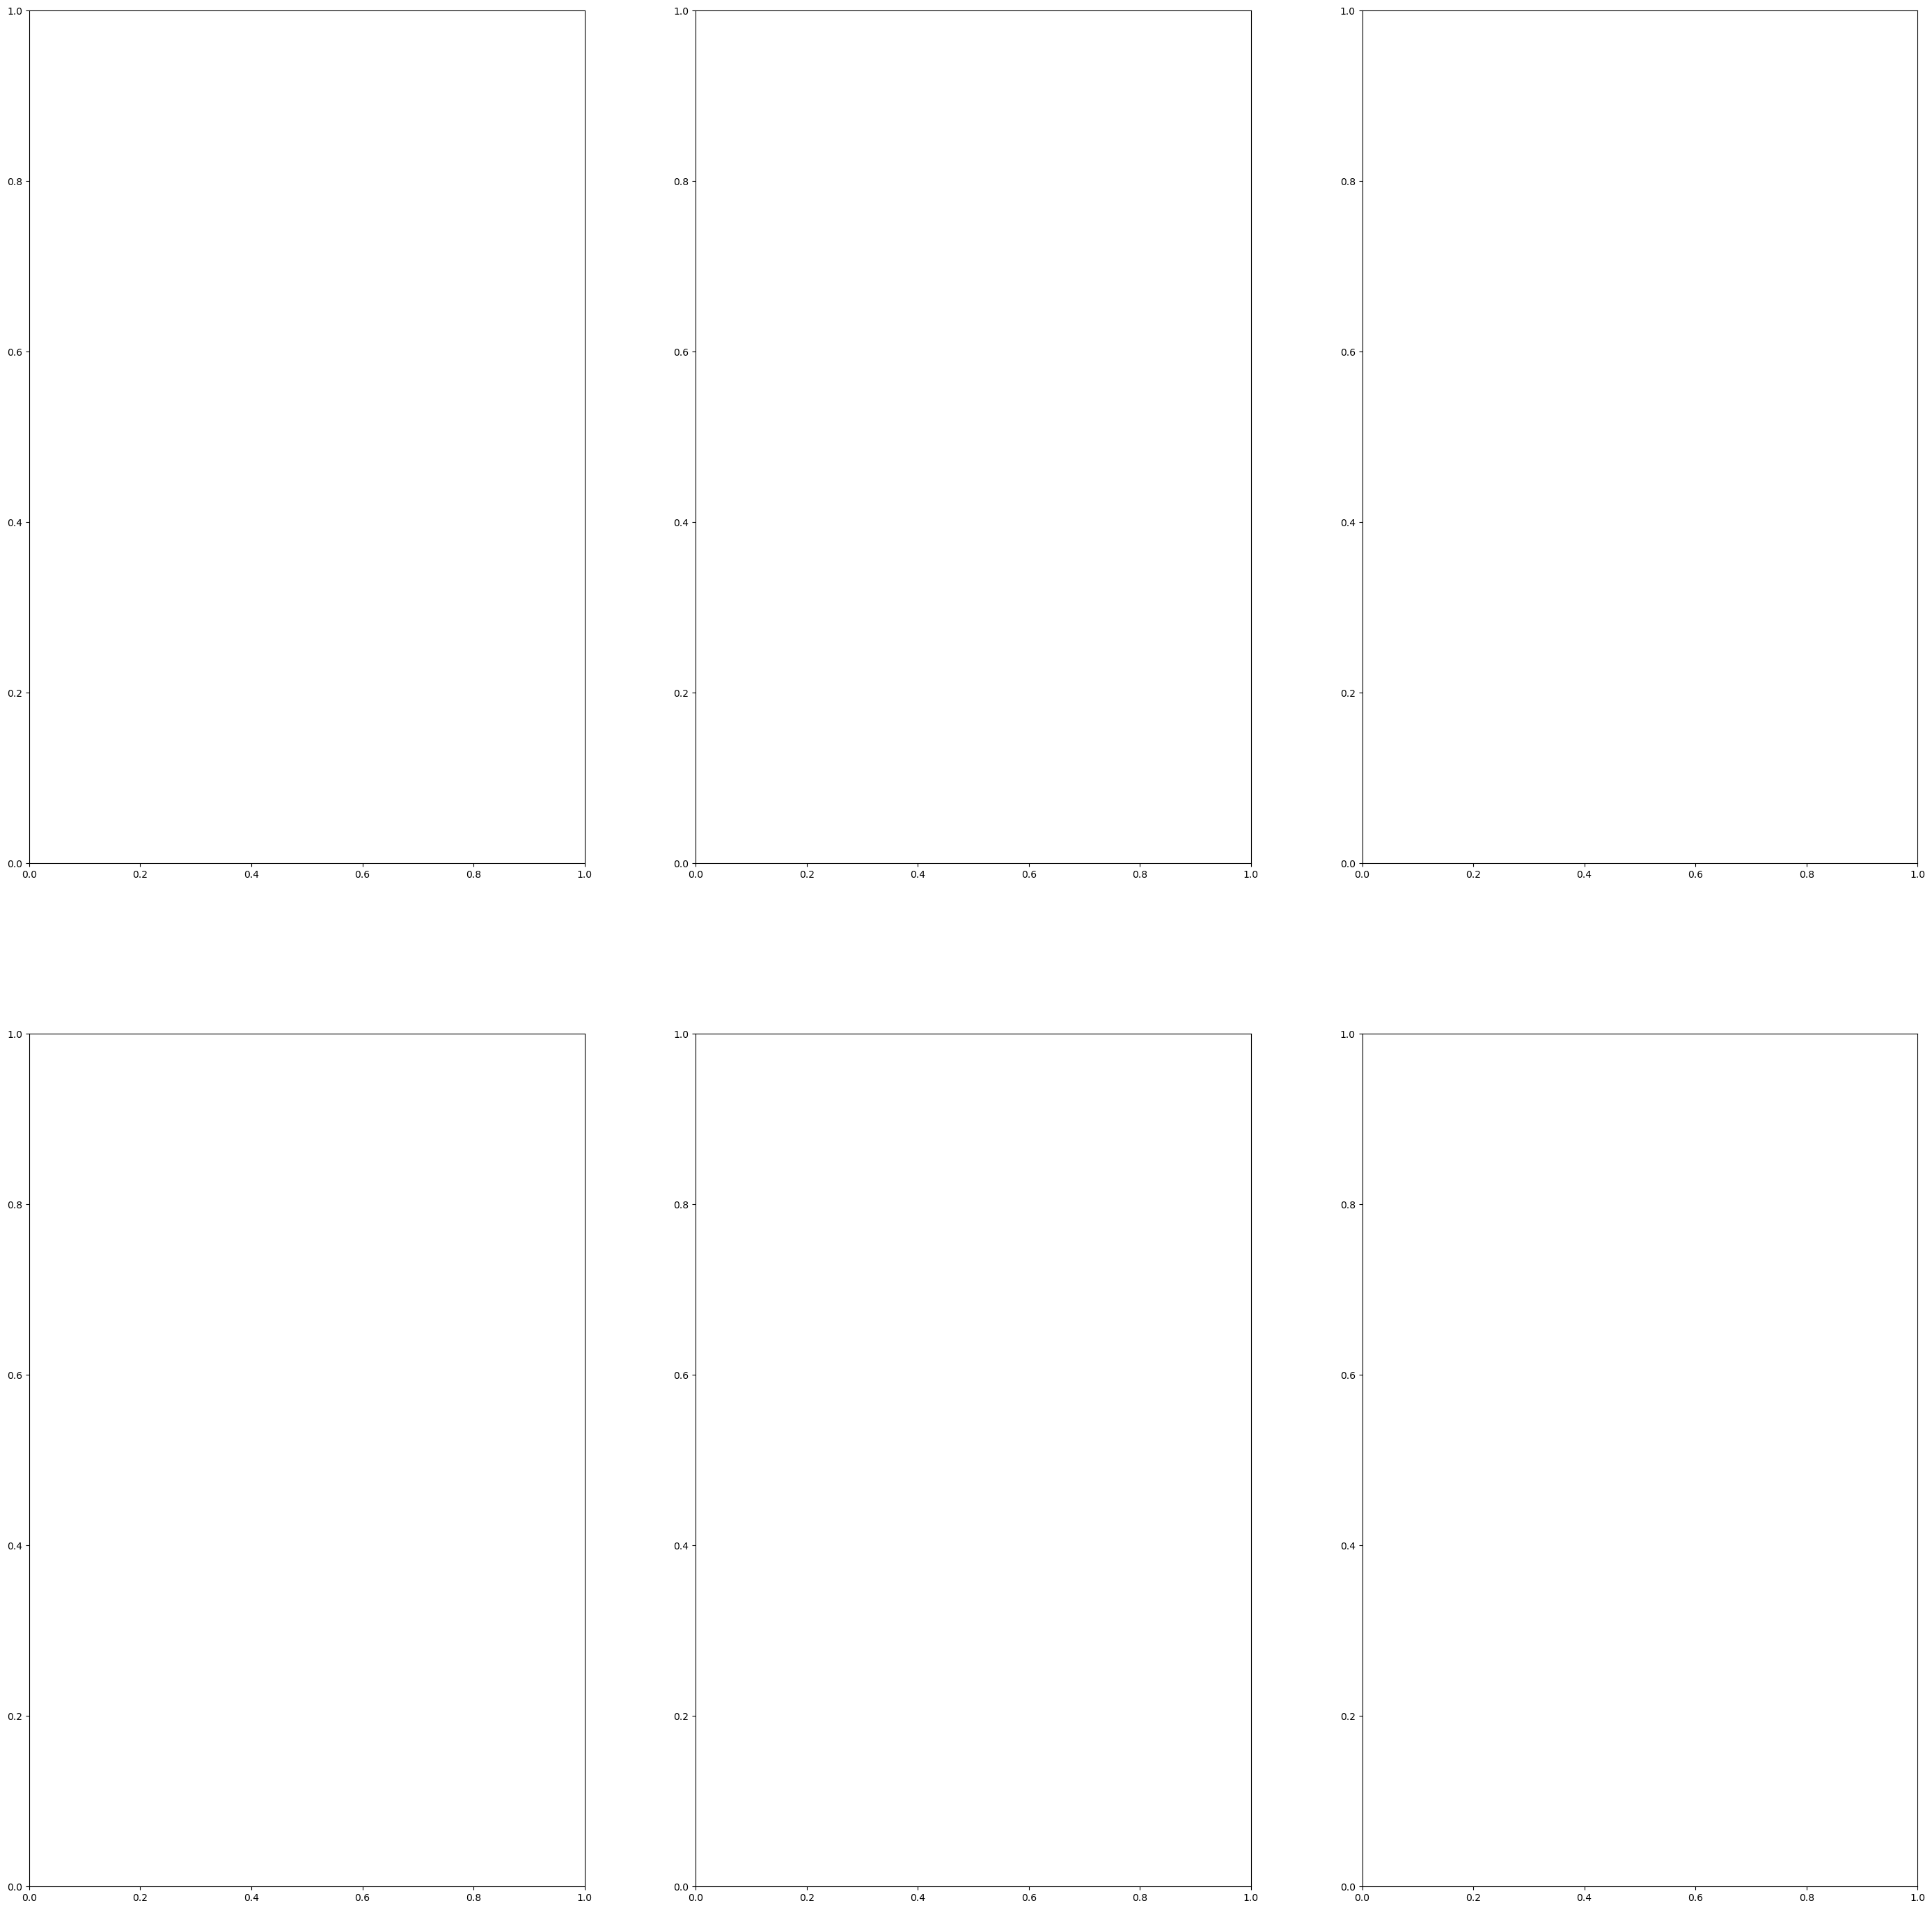

In [34]:
fig, axes = plt.subplots(2, 3, figsize = (35,35))
with np.errstate(divide= 'ignore', invalid = 'ignore'):
    im1 = axes[0,0].pcolormesh(ybl, xbl, ota_sum_lapse_mean/cl, cmap = rev_map, alpha = 0.8)
    im2 = axes[0,1].pcolormesh(ybl, xbl, otd_sum_lapse_mean/cl, cmap = 'cividis', alpha = 0.8)
    im3 = axes[0,2].pcolormesh(ybl, xbl, ott_sum_lapse_mean/cl, cmap = 'magma', alpha = 0.8)

    im4 = axes[1,0].pcolormesh(ybn, xbn, ota_sum_n2_mean/cn, cmap = rev_map, alpha = 0.8)
    im5 = axes[1,1].pcolormesh(ybn, xbn, otd_sum_n2_mean/cn, cmap = 'cividis', alpha = 0.8)
    im6 = axes[1,2].pcolormesh(ybn, xbn, ott_sum_n2_mean/cn, cmap = 'magma', alpha = 0.8)

    axes[0,0].set_title('$\overline{MUCAPE}$ vs $\overline{\Gamma}$', fontsize = 30)
    axes[0,0].set_xlabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[0,0].set_ylabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 30)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[0,0].tick_params(axis='x', labelsize=25)
    axes[0,0].tick_params(axis='y', labelsize=25)
    cbar1 = fig1.colorbar(im1, shrink=0.8)
    cbar1.set_label('OTA', fontsize = 25)
    cbar1.ax.tick_params(labelsize = 15)


    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[0,1].set_title('$\overline{MUCAPE}$ vs $\overline{\Gamma}$', fontsize = 30)
    axes[0,1].set_xlabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[0,1].set_ylabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 30)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[0,1].tick_params(axis='x', labelsize=25)
    axes[0,1].tick_params(axis='y', labelsize=25)

    cbar2 = fig1.colorbar(im2,  shrink=0.8)
    cbar2.set_label('OTD', fontsize = 25)
    cbar2.ax.tick_params(labelsize = 15)




    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[0,2].set_title('$\overline{MUCAPE}$ vs $\overline{\Gamma}$', fontsize = 30)
    axes[0,2].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[0,2].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 30)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[0,2].tick_params(axis='x', labelsize=25)
    axes[0,2].tick_params(axis='y', labelsize=25)


    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[1,0].set_title('$\overline{MUCAPE}$ vs $\overline{N^{2}}$', fontsize = 30)
    axes[1,0].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[1,0].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 30)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[1,0].tick_params(axis='x', labelsize=25)
    axes[1,0].tick_params(axis='y', labelsize=25)


    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[1,1].set_title('$\overline{MUCAPE}$ vs $\overline{N^{2}}$', fontsize = 30)
    axes[1,1].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[1,1].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 30)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[1,1].tick_params(axis='x', labelsize=25)
    axes[1,1].tick_params(axis='y', labelsize=25)


    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[1,2].set_title('$\overline{MUCAPE}$ vs $\overline{N^{2}}$', fontsize = 30)
    axes[1,2].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[1,2].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 30)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[1,2].tick_params(axis='x', labelsize=25)
    axes[1,2].tick_params(axis='y', labelsize=25)

    cbar3 = fig1.colorbar(im3,  shrink=0.8)
    cbar3.set_label('OTT', fontsize = 25)
    cbar3.ax.tick_params(labelsize = 15)

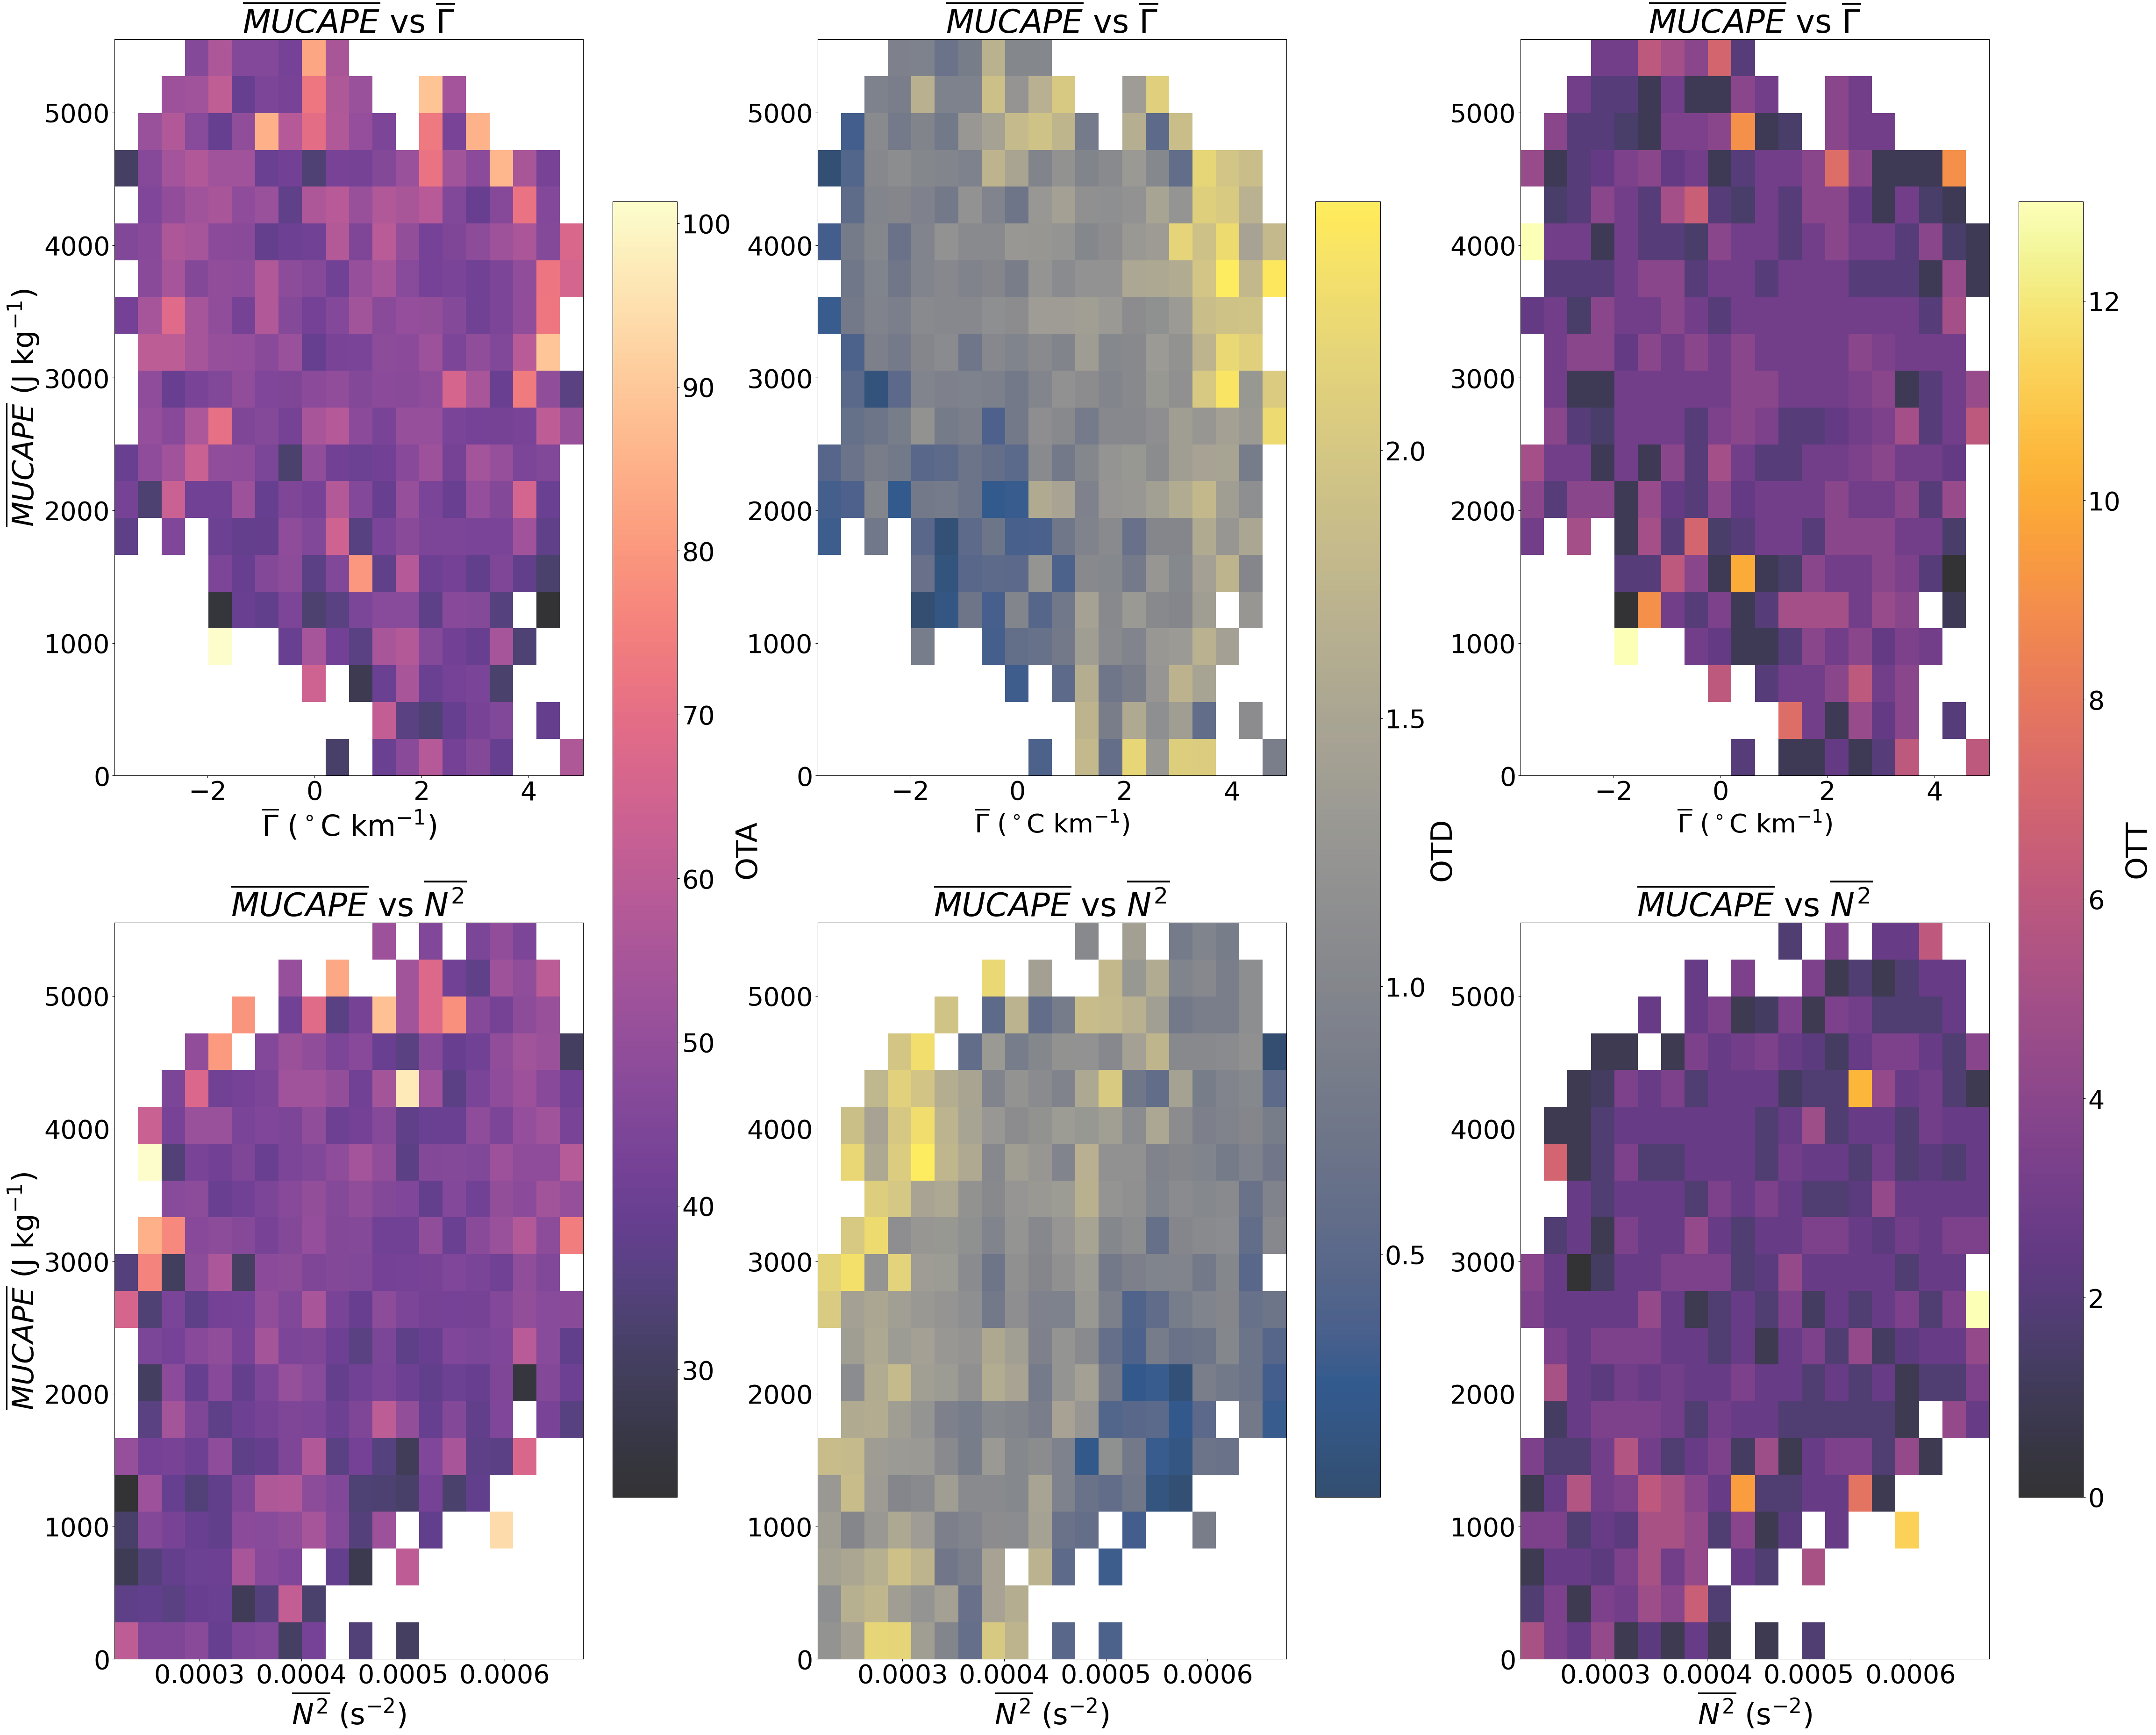

In [35]:
fig, axes = plt.subplots(2, 3, figsize = (55,45))
with np.errstate(divide= 'ignore', invalid = 'ignore'):
    im1 = axes[0,0].pcolormesh(ybl, xbl, ota_binned_lapse_med.statistic, cmap = 'magma', alpha = 0.8)
    im2 = axes[0,1].pcolormesh(ybl, xbl, otd_binned_lapse_med.statistic, cmap = 'cividis', alpha = 0.8)
    im3 = axes[0,2].pcolormesh(ybl, xbl, ott_binned_lapse_med.statistic, cmap = 'inferno', alpha = 0.8)

    im4 = axes[1,0].pcolormesh(ybn, xbn, ota_binned_n2_med.statistic, cmap = 'magma', alpha = 0.8)
    im5 = axes[1,1].pcolormesh(ybn, xbn, otd_binned_n2_med.statistic, cmap = 'cividis', alpha = 0.8)
    im6 = axes[1,2].pcolormesh(ybn, xbn, ott_binned_n2_med.statistic, cmap = 'inferno', alpha = 0.8)

    axes[0,0].set_title('$\overline{MUCAPE}$ vs $\overline{\Gamma}$', fontsize = 50)
    axes[0,0].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 45)
    axes[0,0].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 45)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[0,0].tick_params(axis='x', labelsize=40)
    axes[0,0].tick_params(axis='y', labelsize=40)
    cbar1 = fig.colorbar(im1, ax = axes[:,0], shrink=0.8)
    cbar1.set_label('OTA', fontsize = 45)
    cbar1.ax.tick_params(labelsize = 40)


    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[0,1].set_title('$\overline{MUCAPE}$ vs $\overline{\Gamma}$', fontsize = 50)
    #axes[0,1].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[0,1].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 40)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[0,1].tick_params(axis='x', labelsize=40)
    axes[0,1].tick_params(axis='y', labelsize=40)

    cbar2 = fig.colorbar(im2, ax = axes[:,1], shrink=0.8)
    cbar2.set_label('OTD', fontsize = 45)
    cbar2.ax.tick_params(labelsize = 40)




    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[0,2].set_title('$\overline{MUCAPE}$ vs $\overline{\Gamma}$', fontsize = 50)
    #axes[0,2].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[0,2].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 40)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[0,2].tick_params(axis='x', labelsize=40)
    axes[0,2].tick_params(axis='y', labelsize=40)


    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[1,0].set_title('$\overline{MUCAPE}$ vs $\overline{N^{2}}$', fontsize = 50)
    axes[1,0].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 45)
    axes[1,0].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 45)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[1,0].tick_params(axis='x', labelsize=40)
    axes[1,0].tick_params(axis='y', labelsize=40)


    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[1,1].set_title('$\overline{MUCAPE}$ vs $\overline{N^{2}}$', fontsize = 50)
    #axes[1,1].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[1,1].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 45)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[1,1].tick_params(axis='x', labelsize=40)
    axes[1,1].tick_params(axis='y', labelsize=40)


    #axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
    #axes[0,0].plot(x5, y5, '-k')
    #axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
    axes[1,2].set_title('$\overline{MUCAPE}$ vs $\overline{N^{2}}$', fontsize = 50)
    #axes[1,2].set_ylabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 30)
    axes[1,2].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 45)
    #axes[0,0].legend( loc = 'best', fontsize = 10)
    axes[1,2].tick_params(axis='x', labelsize=40)
    axes[1,2].tick_params(axis='y', labelsize=40)

    cbar3 = fig.colorbar(im3, ax = axes[:, 2], shrink=0.8)
    cbar3.set_label('OTT', fontsize = 45)
    cbar3.ax.tick_params(labelsize = 40)

In [36]:
mean_area = grouped_ots.mean("area_polygon")
mean_depth = grouped_ots.mean("dz_lowest85")

In [37]:
mam = np.mean(mean_area['area_polygon'].values)
mdm = np.mean(mean_depth['dz_lowest_85'].values)

mam, mdm


(51.70512229054097, 1.1108595180309688)

In [38]:
mean_area['hour'] = mean_area['hour'].astype(int)
mean_depth['hour'] = mean_depth['hour'].astype(int)

In [39]:
nov_stats = gpd_jan25[gpd_jan25.month == 11]
dec_stats = gpd_jan25[gpd_jan25.month == 12]
jan_stats = gpd_jan25[gpd_jan25.month == 1] 
feb_stats = gpd_jan25[gpd_jan25.month == 2]
grouped_nov = nov_stats.groupby('cell')
grouped_dec = dec_stats.groupby('cell')
grouped_jan = jan_stats.groupby('cell')
grouped_feb = feb_stats.groupby('cell')

In [40]:
nov_area = grouped_nov.mean("area_polygon").area_polygon
nov_depth = grouped_nov.mean("dz_lowest_85").dz_lowest_85
meana_nov = np.mean(nov_area)
meand_nov = np.mean(nov_depth)

dec_area = grouped_dec.mean("area_polygon").area_polygon
dec_depth = grouped_dec.mean("dz_lowest_85").dz_lowest_85
meana_dec = np.mean(dec_area)
meand_dec = np.mean(dec_depth)

jan_area = grouped_jan.mean("area_polygon").area_polygon
jan_depth = grouped_jan.mean("dz_lowest_85").dz_lowest_85
meana_jan = np.mean(jan_area)
meand_jan = np.mean(jan_depth)

feb_area = grouped_feb.mean("area_polygon").area_polygon
feb_depth = grouped_feb.mean("dz_lowest_85").dz_lowest_85
meana_feb = np.mean(feb_area)
meand_feb = np.mean(feb_depth)

print(meana_nov, meana_dec, meana_jan, meana_feb)

print(meand_nov, meand_dec, meand_jan, meand_feb)

49.01669862153838 51.825813107342135 53.0002805860086 53.41916782445277
1.0932400978112853 1.1743974219284183 1.0664675024966401 1.1214337061866688


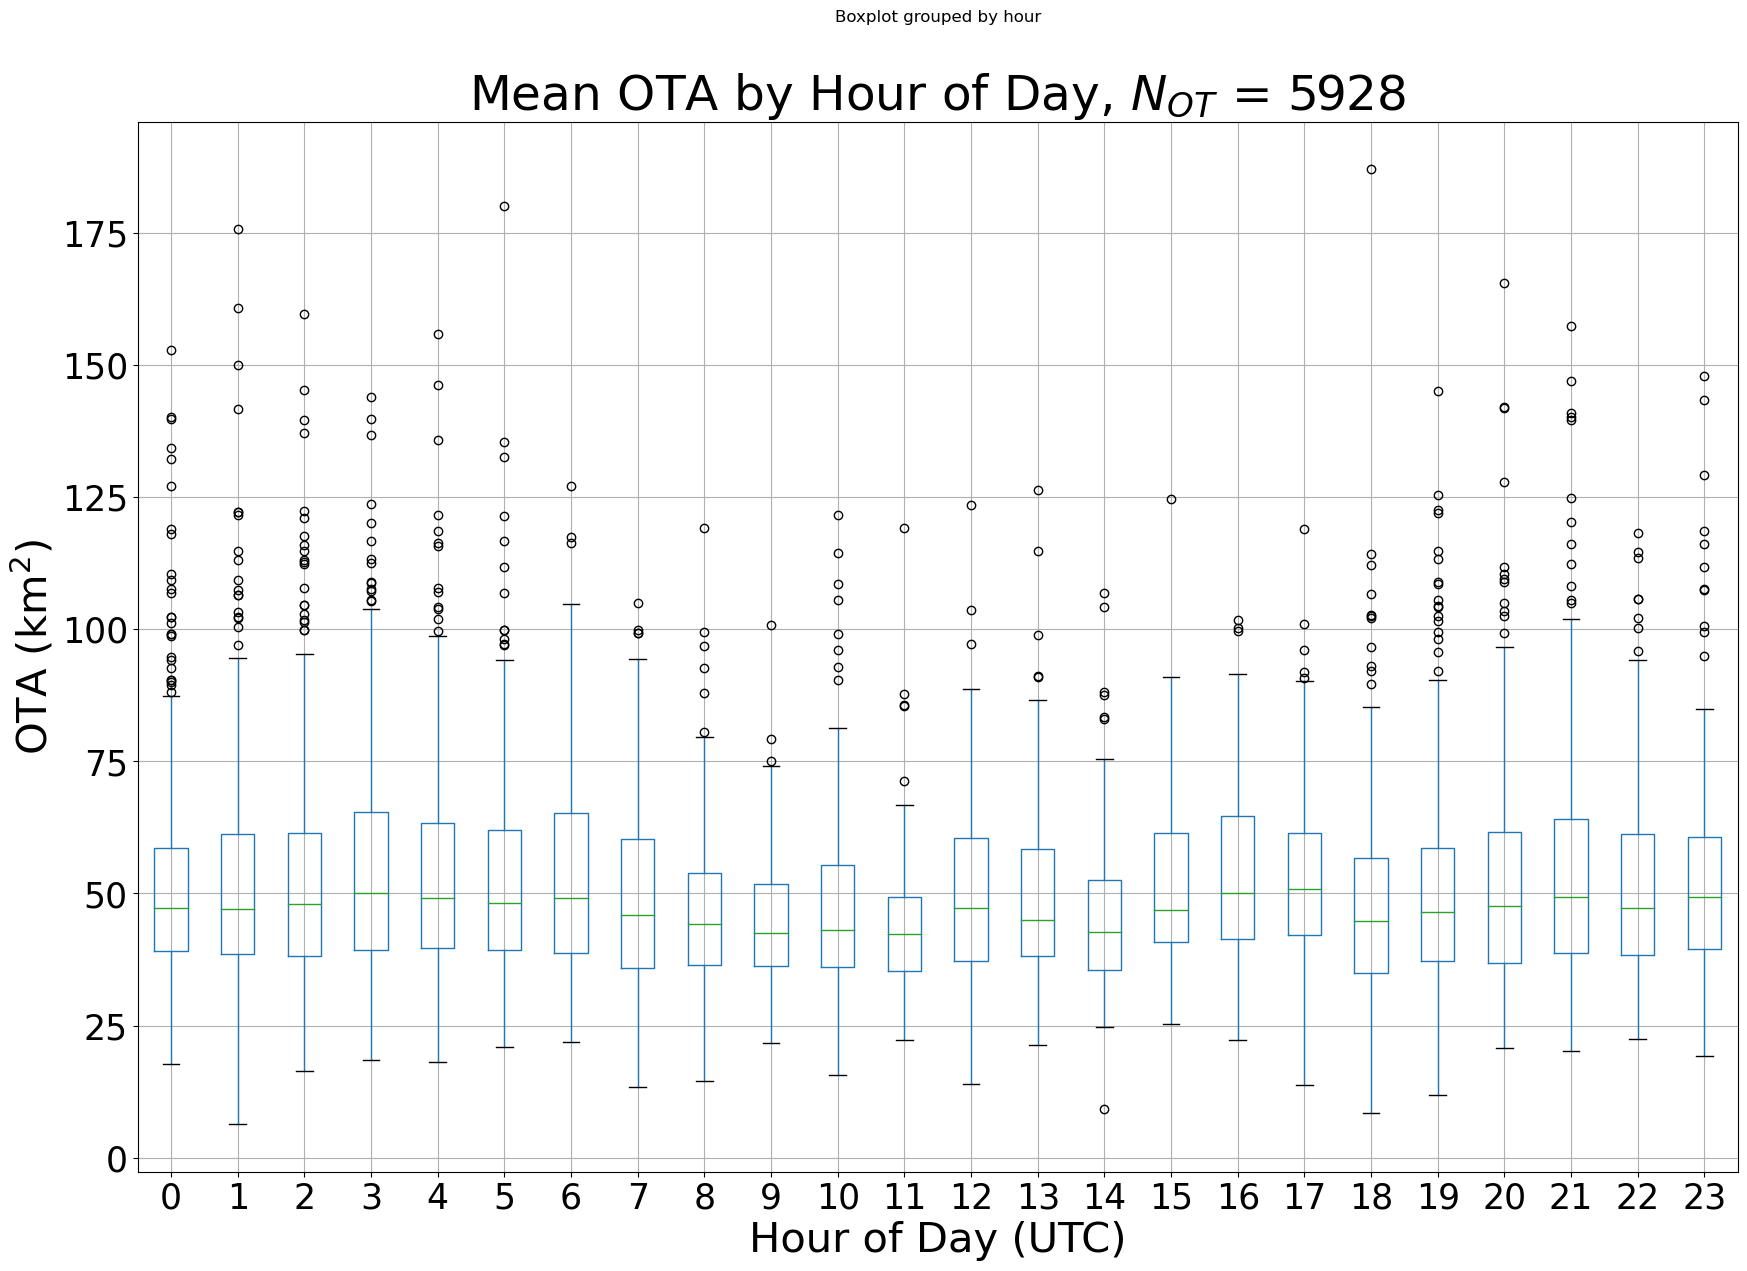

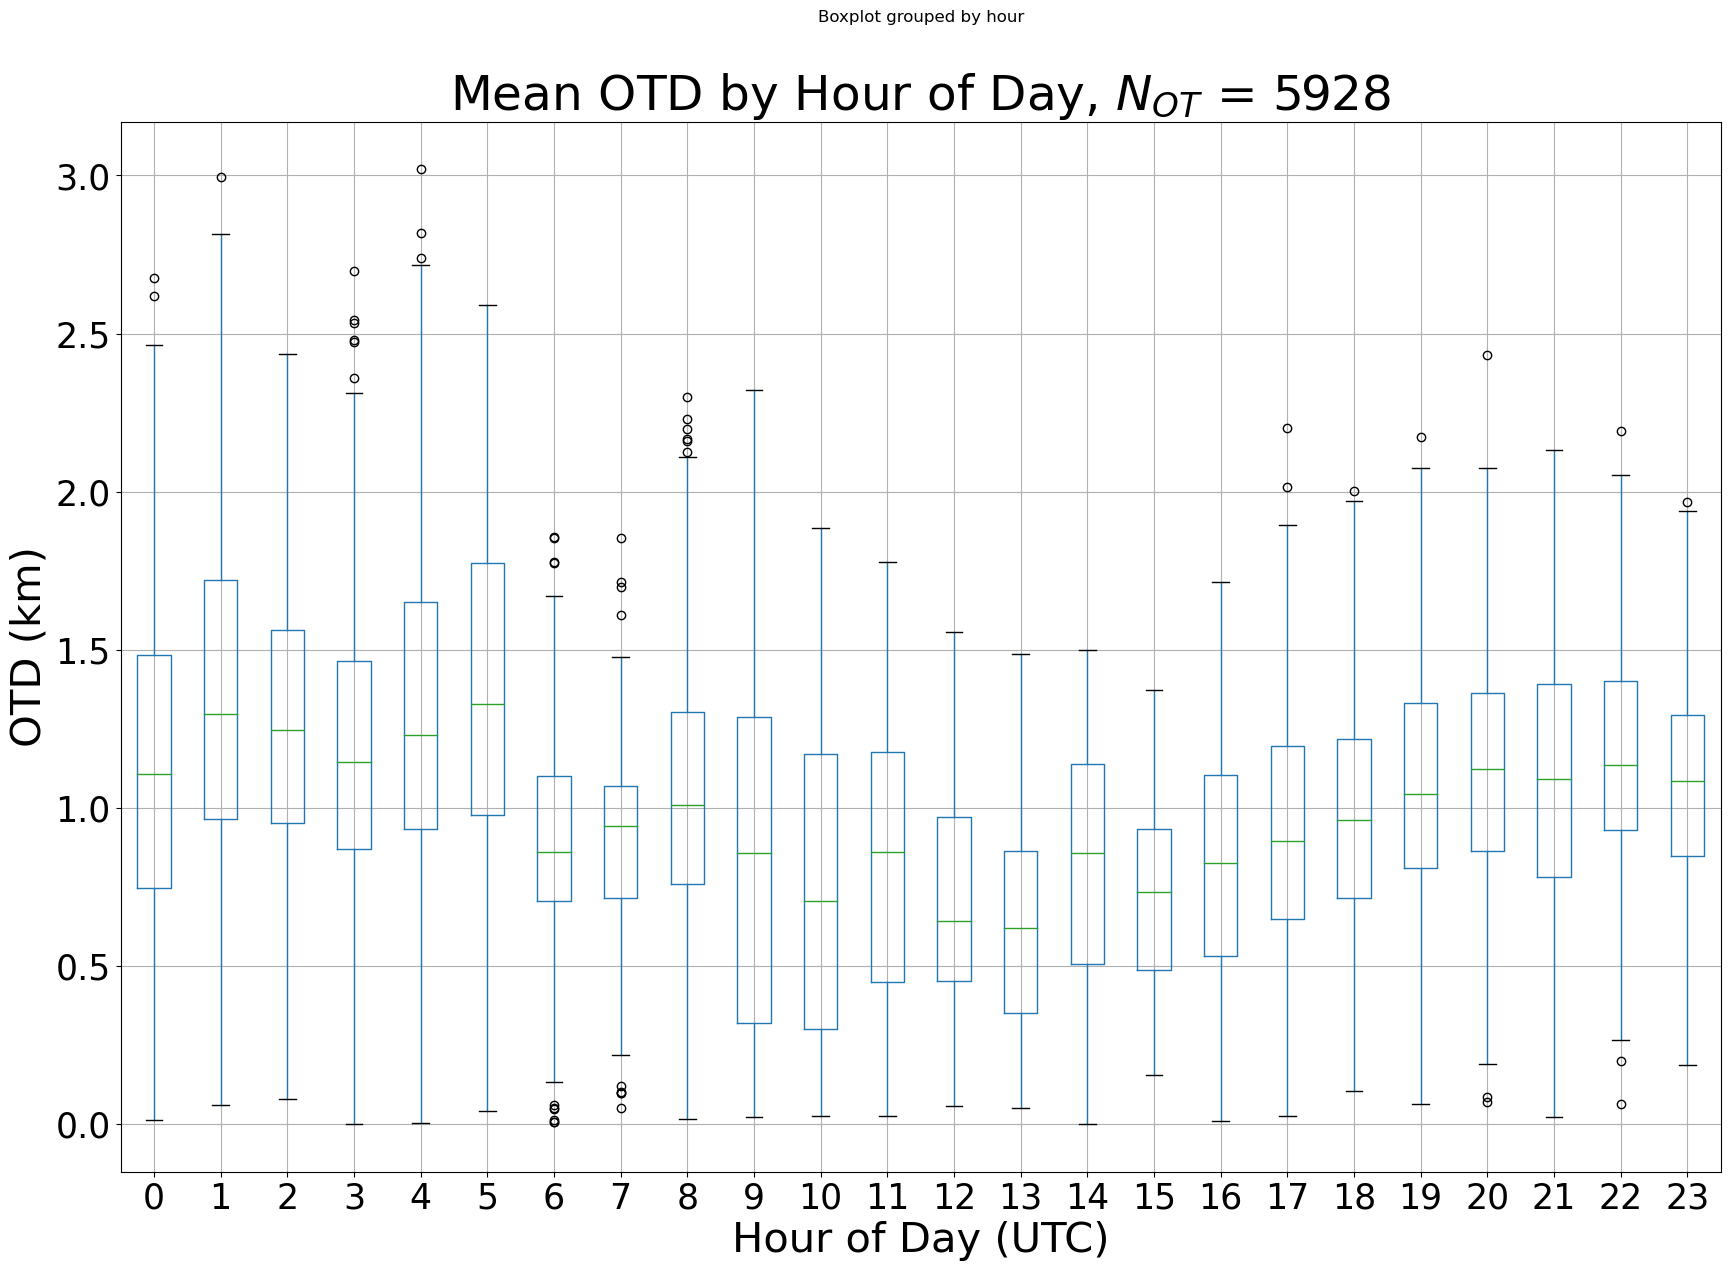

In [41]:
bpa = mean_area.boxplot(column='area_polygon', by='hour', figsize = (20, 14))
bpa.set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 30)
bpa.set_xlabel('Hour of Day (UTC)', fontsize = 30)
bpa.tick_params(axis='x', labelsize=25)
bpa.tick_params(axis='y', labelsize = 25)
bpa.set_title('$\overline{OTA}$ by Hour of Day, $N_{OT}$ = %0.0f'%len(mucape), fontsize = 35)
#plt.savefig('ota_hour_9.8_lapse.png')

bpd = mean_depth.boxplot(column='dz_lowest_85', by = 'hour', figsize = (20, 14))
bpd.set_ylabel('$\overline{OTD}$ (km)', fontsize = 30)
bpd.set_xlabel('Hour of Day (UTC)', fontsize = 30)
bpd.set_title('$\overline{OTD}$ by Hour of Day, $N_{OT}$ = %0.0f'%len(mucape), fontsize = 35)
bpd.tick_params(axis='x', labelsize=25)
bpd.tick_params(axis='y', labelsize = 25)
#plt.savefig('otd_hour9_lapse.png')



Text(0.5, 1.0, 'All OT Tracks, N = 5928')

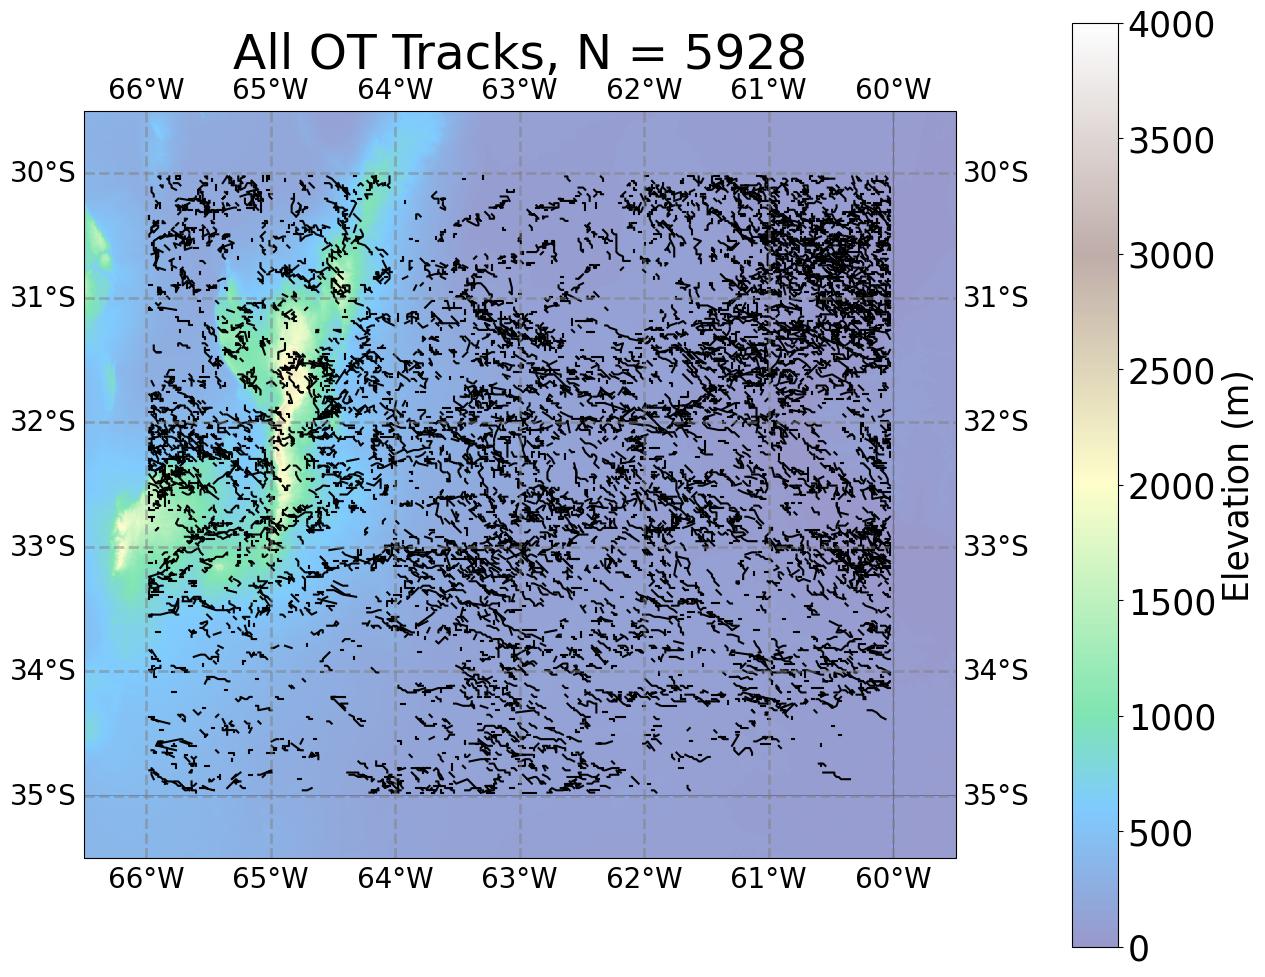

In [42]:
llcrnr=[-35.5, -66.5]
urcrnr=[-29.5, -59.5]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})


ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain', alpha = 0.5)

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size':20}
gl.ylabel_style = {'size':20}
cb1 = plt.colorbar(cm,shrink=0.8, pad=0.1)
cb1.set_label('Elevation (m)', fontsize = 25)
for name, group in grouped_ots:
    tracks = grouped_ots.get_group(name)
    plt.plot(tracks.lon, tracks.lat, color = 'k')
cb1.ax.tick_params(labelsize = 25)

plt.title('All OT Tracks, N = %0.0f'%len(ota_25jan), fontsize = 35)

In [43]:
max_lats = grouped_ots.max('area_polygon').lat
max_lons = grouped_ots.max('area_polygon').lon
max_lons_depth = grouped_ots.max('dz_lowest_85').lon
max_lats_depth = grouped_ots.max('dz_lowest_85').lat
max_area = grouped_ots.max('area_polygon').area_polygon
max_depth = grouped_ots.max('dz_lowest_85').dz_lowest_85
duration = grouped_ots.duration.nth(0)

samples = len(max_lats)

Text(0.5, 1.0, 'Max OTA, N = 5928')

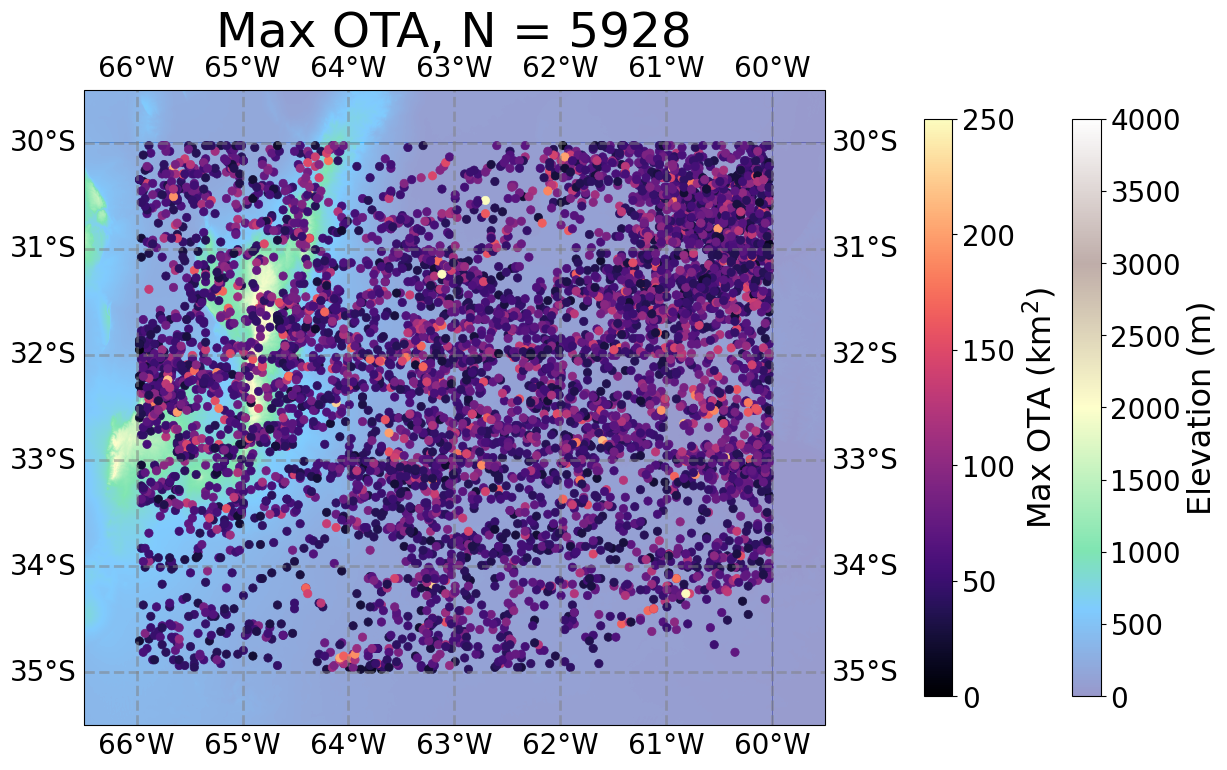

In [44]:
import cartopy.crs as ccrs
llcrnr=[-35.5, -66.5]
urcrnr=[-29.5, -59.5]
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]] 
ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain', alpha = 0.5)

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size':20}
gl.ylabel_style = {'size':20}

cm2 = plt.scatter(max_lons, max_lats,c=max_area,vmin=0.,vmax=250.,
                     facecolors='none',cmap='magma',linewidth=0.5)

cb1 = plt.colorbar(cm, shrink=0.5, pad=0.0)
cb1.set_label('Elevation (m)', fontsize = 23)
cb1.ax.tick_params(labelsize = 20)
cb2 = plt.colorbar(cm2, shrink=0.5, pad=0.1)
cb2.set_label('Max OTA (km$^{2}$)', fontsize = 23)
cb2.ax.tick_params(labelsize = 20)

ax_map.set_title('Max OTA, N = %0.0f'%len(max_area), fontsize = 35)

Text(0.5, 1.0, 'Max OTD, N = 5928')

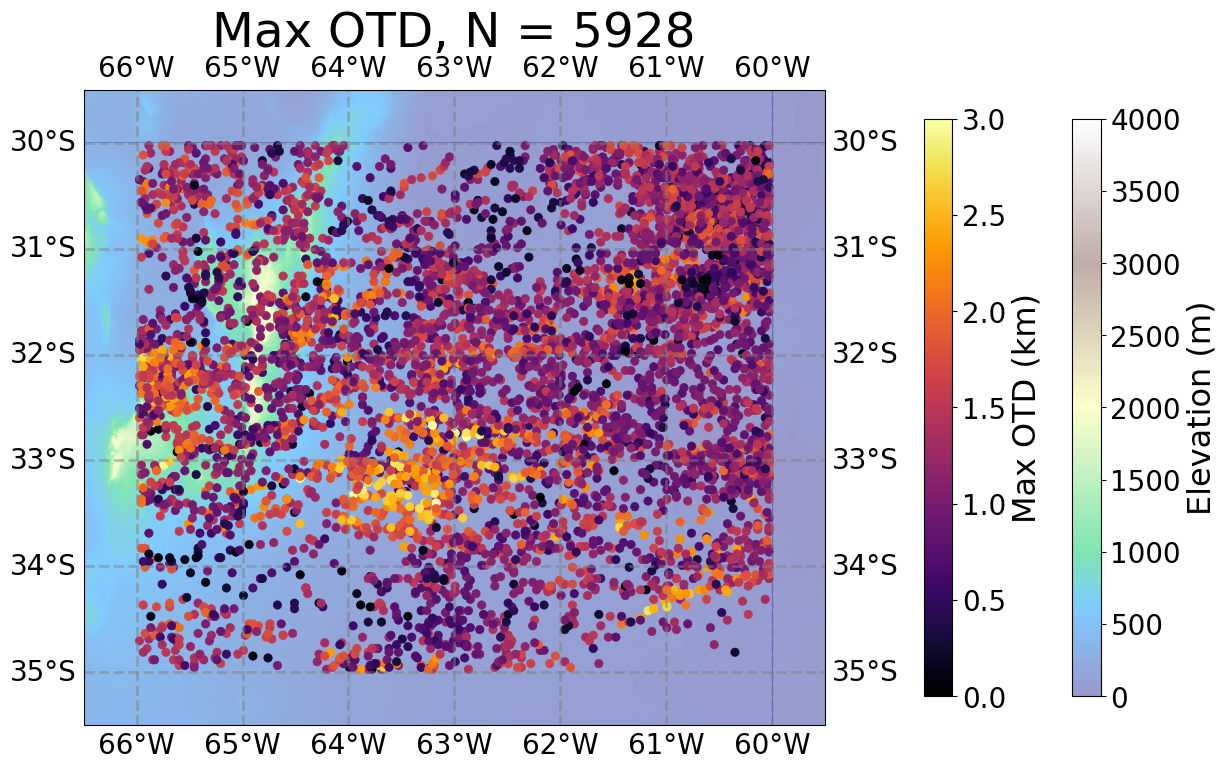

In [45]:
llcrnr=[-35.5, -66.5]
urcrnr=[-29.5, -59.5]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain', alpha = 0.5)

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size':20}
gl.ylabel_style = {'size':20}

cm2 = plt.scatter(max_lons_depth, max_lats_depth,c=max_depth, vmin=0.,vmax=3.,
                     facecolors='none',cmap='inferno',linewidth=0.5)

cb1 = plt.colorbar(cm, shrink=0.5, pad=0.0)
cb1.set_label('Elevation (m)', fontsize = 23)
cb1.ax.tick_params(labelsize = 20)
cb2 = plt.colorbar(cm2, shrink=0.5, pad=0.1)
cb2.set_label('Max OTD (km)', fontsize = 23)
cb2.ax.tick_params(labelsize = 20)



ax_map.set_title('Max OTD, N = %0.0f'%len(max_depth), fontsize = 35)
#plt.savefig('otd_map_9_lapse.png')

In [15]:
files_count = {}

In [71]:
import glob
datestr='20190211'
for hr in np.arange(0,24,1):
        if hr <=9:
                files = sorted(glob.glob(f'/data/accp/a/snesbitt/arm/goesV2/*{datestr}.0{hr}????.cdf'))
                files_count[hr] =  files_count[hr] + len(files)
        else:
                files = sorted(glob.glob(f'/data/accp/a/snesbitt/arm/goesV2/*{datestr}.{hr}????.cdf')) 
                files_count[hr] =   files_count[hr] + len(files)

In [72]:
file_df = pd.DataFrame(data=files_count, index = np.arange(0,24,1))

files_hourly = file_df.iloc[0]

In [83]:
files_hourly

0     1612
1     1650
2     1680
3     1500
4     1500
5     1500
6     1380
7     1380
8     1293
9     1314
10    1261
11    1260
12    1605
13    1642
14    1800
15    2080
16    2160
17    2094
18    1921
19    1860
20    1858
21    1860
22    1918
23    1920
Name: 0, dtype: int64

In [35]:
files_12 = np.array([1605, 1642, 1800, 2080, 2160, 2094, 1921, 1860, 1858, 1860, 1918, 1920, 1612, 1650, 1680, 1500, 1500, 1500, 1380, 1380, 1293, 1314, 1261, 1260])
counts_12 = np.array([575, 547, 452, 235, 528, 822, 1213, 1541, 1425, 1679, 1479, 1378, 1815, 2668, 2846, 2154, 1954, 1191, 693, 780, 654, 654, 532, 357])

In [34]:
counts_per_hour

2     2846
1     2668
3     2154
4     1954
0     1815
21    1679
19    1541
22    1479
20    1425
23    1378
18    1213
5     1191
17     822
7      780
6      693
8      654
9      654
12     575
13     547
10     532
16     528
14     452
11     357
15     235
Name: hours, dtype: int64

In [36]:
counts_per_hour = gpd_jan25['hours'].value_counts()
sum_cph = sum(counts_per_hour)
files_normed = counts_12/files_12
files_normed_12 = counts_12/files_12
hrs = np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4,5,6,7,8,9,10,11])

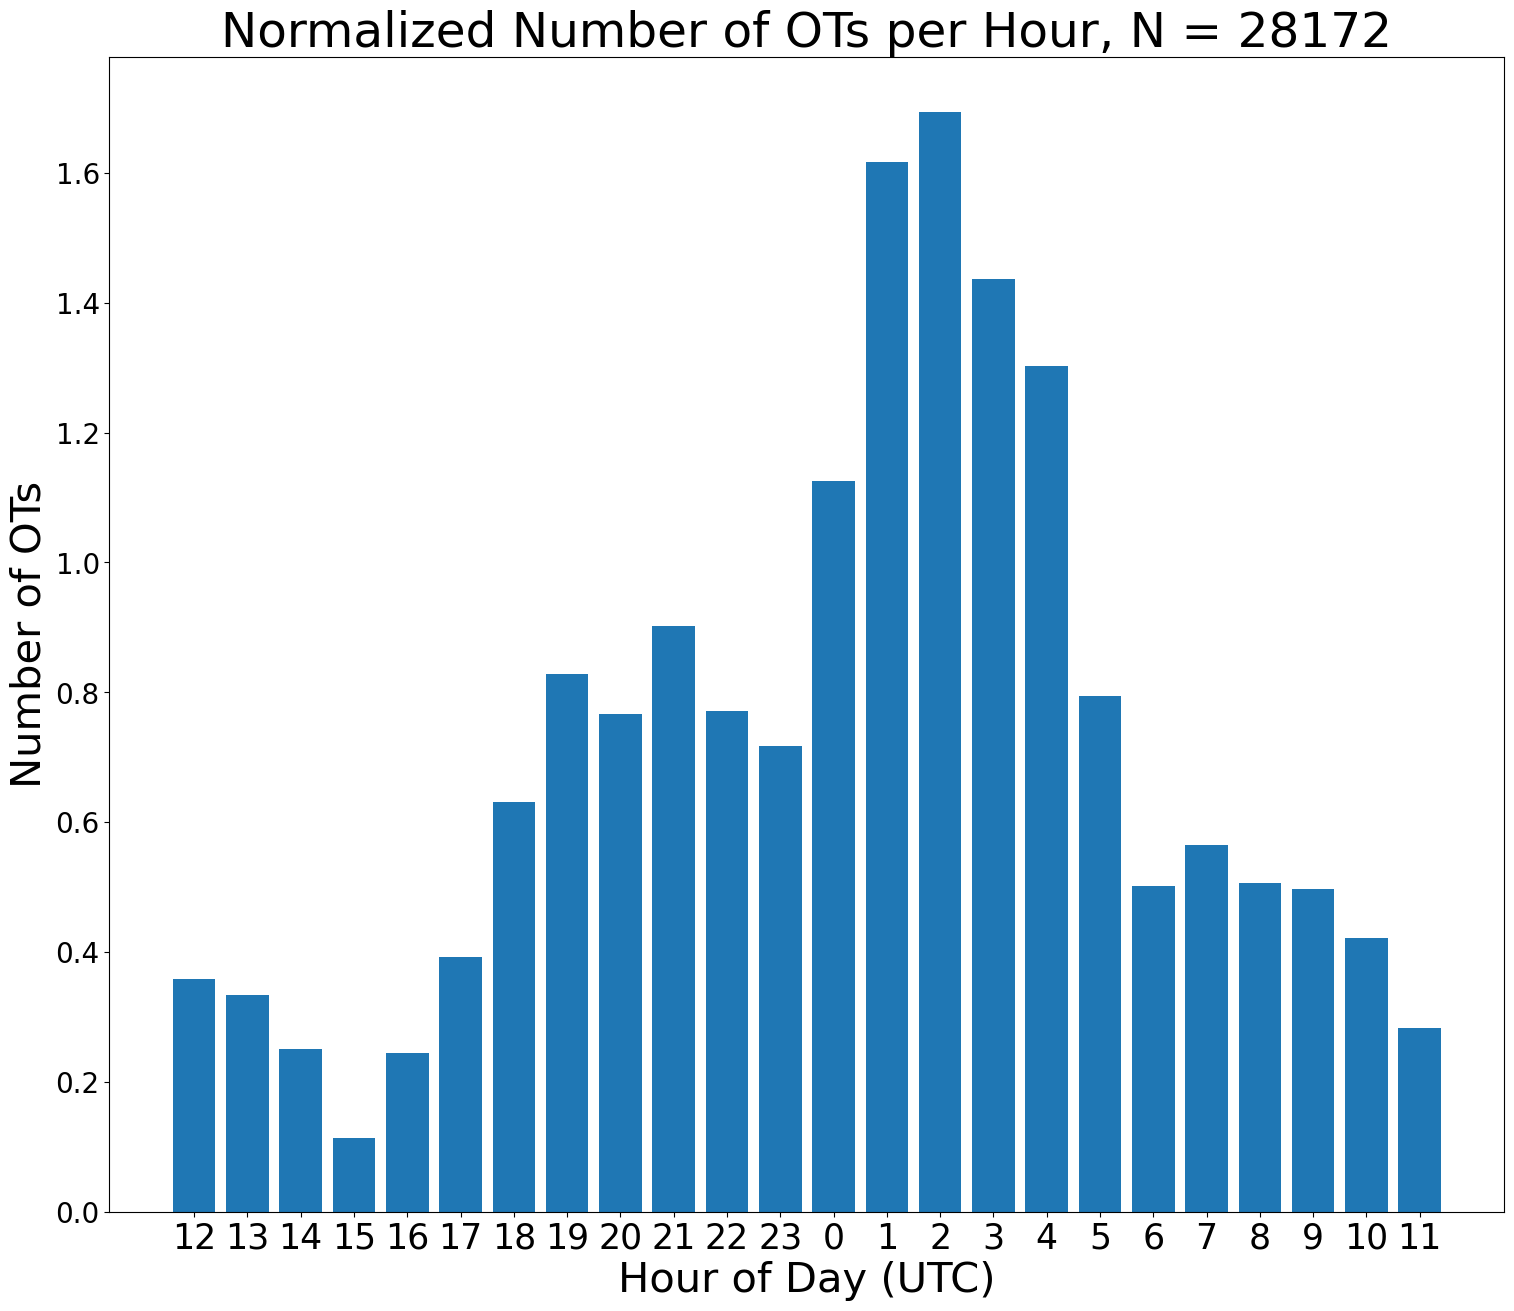

In [37]:
fig, ax = plt.subplots(figsize = (18,15))
plt.bar(range(len(files_normed_12)), height = files_normed_12, tick_label=hrs)
plt.title('Normalized Number of OTs per Hour, N = %0.0f'%sum_cph, fontsize = 35)
plt.xlabel('Hour of Day (UTC)', fontsize = 30)
plt.ylabel('Number of OTs', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 20)
ax.set_xticks(hrs)

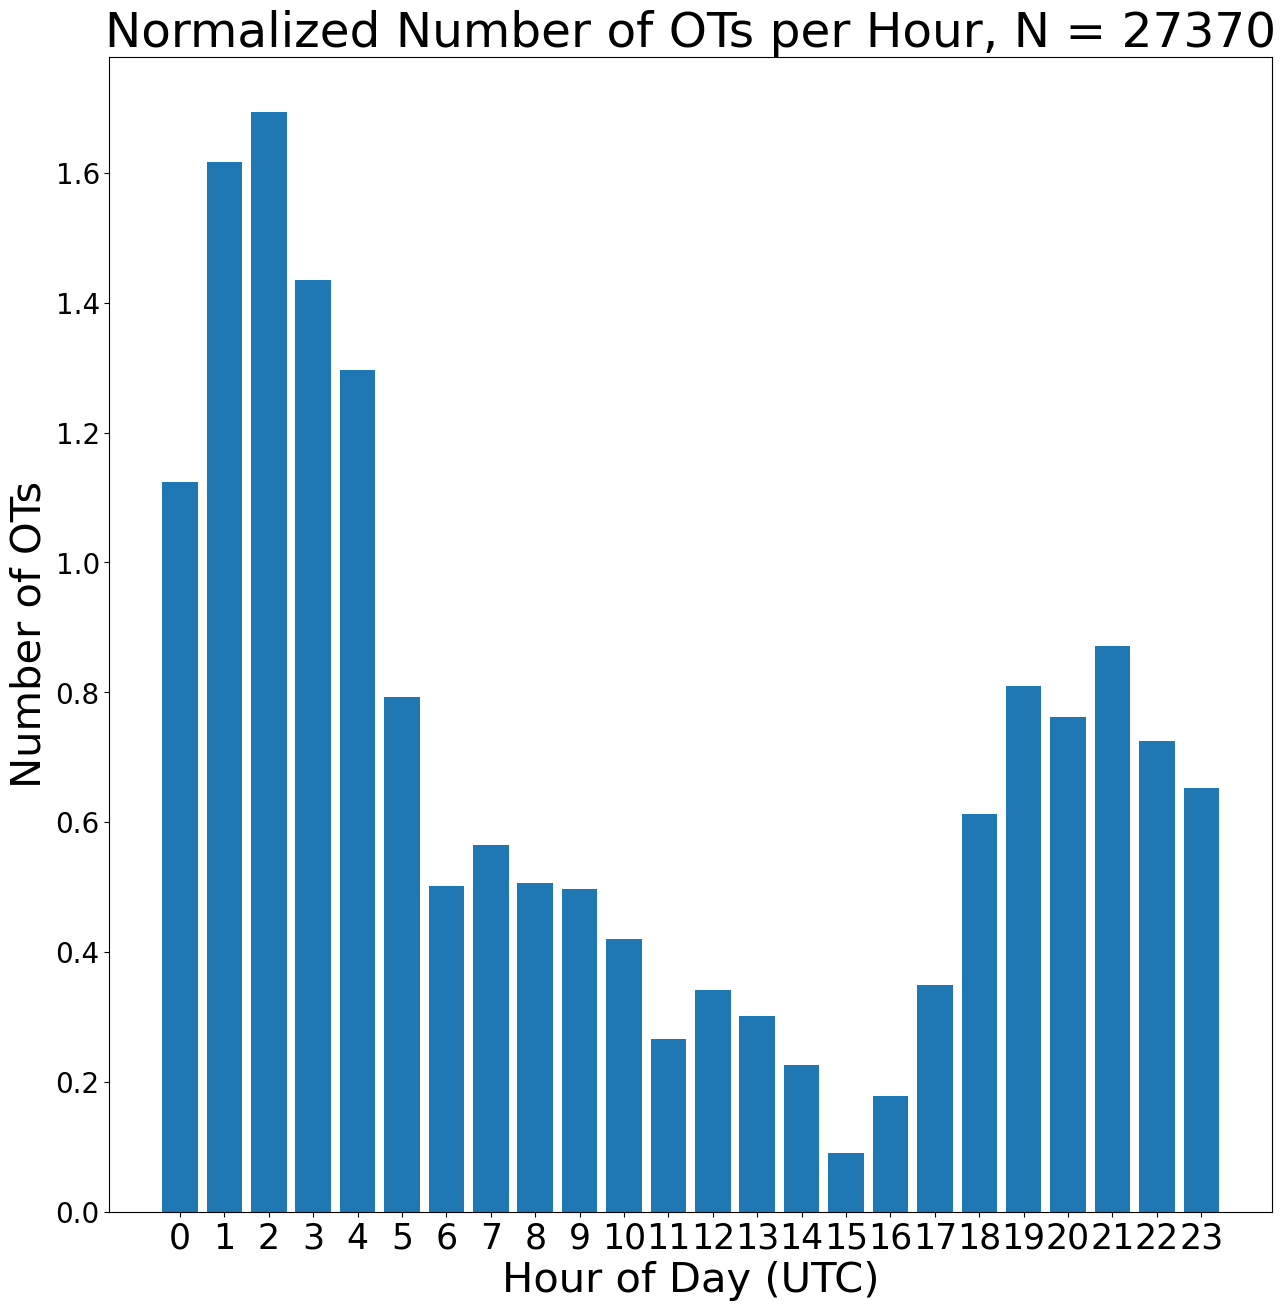

In [74]:
fig, ax = plt.subplots(figsize = (15,15))
plt.bar(hrs, files_normed)
plt.title('Normalized Number of OTs per Hour, N = %0.0f'%sum_cph, fontsize = 35)
plt.xlabel('Hour of Day (UTC)', fontsize = 30)
plt.ylabel('Number of OTs', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 20)
ax.set_xticks(hrs)

In [57]:
grouped_by_day = gpd_jan25.groupby(gpd_jan25.index)
date_list = list(grouped_by_day.groups.keys())

In [61]:
date_list[390:400]

[Timestamp('2018-11-10 22:00:55.000000512'),
 Timestamp('2018-11-10 22:01:55.000000512'),
 Timestamp('2018-11-10 22:02:54.999999488'),
 Timestamp('2018-11-10 22:03:55.000000512'),
 Timestamp('2018-11-10 22:04:55.000000512'),
 Timestamp('2018-11-10 22:05:54.999999488'),
 Timestamp('2018-11-10 22:06:54.999999488'),
 Timestamp('2018-11-10 22:07:55.000000512'),
 Timestamp('2018-11-10 22:08:55.000000512'),
 Timestamp('2018-11-10 22:09:54.999999488')]

In [63]:
import matplotlib.animation as anim
import glob
lat_track = []
lon_track = []
ot_dict = {}
for i in date_list[395:410]:
    fig, ax = plt.subplots(figsize= (12,12))
    file = glob.glob(f"/data/accp/a/snesbitt/arm/goesV2/cor1goecnvv2X1.a1.{i:%Y%m%d.%H%M}*.cdf")
    test_file = xr.open_dataset(file[0])
    ir_temps = test_file.ir_brightness_temperature[0].values
    lons = test_file.longitude.values
    lats = test_file.latitude.values
    plt.pcolormesh(lons, lats, ir_temps, cmap = rev_map)
    plt.title(pd.to_datetime(test_file.time.values[0]).strftime('%d %b %y %H:%M:%S'), fontsize=30)
    plt.ylim(-31.7, -32.7)
    plt.xlim(-64, -63)

    filtered_gpd = gpd_jan25[gpd_jan25.index == i]
    grouped_filts = filtered_gpd.groupby('cell')
    ot_id = list(grouped_filts.groups.keys())
    

    for id in ot_id:
        otids = list(ot_dict.keys())
        lat, lon = grouped_filts.get_group(id).lat.values, grouped_filts.get_group(id).lon.values
        if str(int(id)) in otids:
            ot_dict[f"{int(id)}"]['lats'].extend([np.squeeze(lat).tolist()])
            ot_dict[f"{int(id)}"]['lons'].extend([np.squeeze(lon).tolist()])
        else:
            ot_dict[f"{int(id)}"] = {"lats": [], "lons": []}
            ot_dict[f"{int(id)}"]['lats'] = [np.squeeze(lat).tolist()]
            ot_dict[f"{int(id)}"]['lons'] = [np.squeeze(lon).tolist()]
        
    for k in list(ot_dict.keys()):
        lat = ot_dict[k]['lats']
        lons = ot_dict[k]['lons']
    
        ax.plot(lons, lat, 'o-', markersize = 0.5)
        #ax.set_xlim([-66, -62])
        #ax.set_ylim([-36, -32])
        #ot_dict[f"{id}"] = {'lats': [], 'lons': []}    
    plt.savefig(f'ot_{i:%Y%m%d.%H%M}.png')
    plt.close()

In [14]:
cloudtop_heights

array([0.4257583 , 2.19993597, 1.94595013, ..., 1.56760644, 1.01385811,
       0.83733951])

In [23]:
cloudtop_heights = gpd_jan25['cloudtop_height'].values
trop_heights = gpd_jan25['trop_height'].values

cloudtop_pressure = mpcalc.height_to_pressure_std(cloudtop_heights*units.kilometer)
trop_pressure = mpcalc.height_to_pressure_std(trop_heights*units.kilometer)


cloud_trop_diff = cloudtop_pressure - trop_pressure

In [16]:
cloudtop_pressure

array([94.02826613, 90.08190892, 98.98767541, ..., 68.6976126 ,
       71.88341736, 74.14047886]) <Unit('hectopascal')>

In [28]:
percent_25 = np.percentile(obs_top, 50)
percent_75 = np.percentile(obs_top, 99)

print(percent_25, percent_75)

68.25825980838238 hectopascal 150.33969942444978 hectopascal


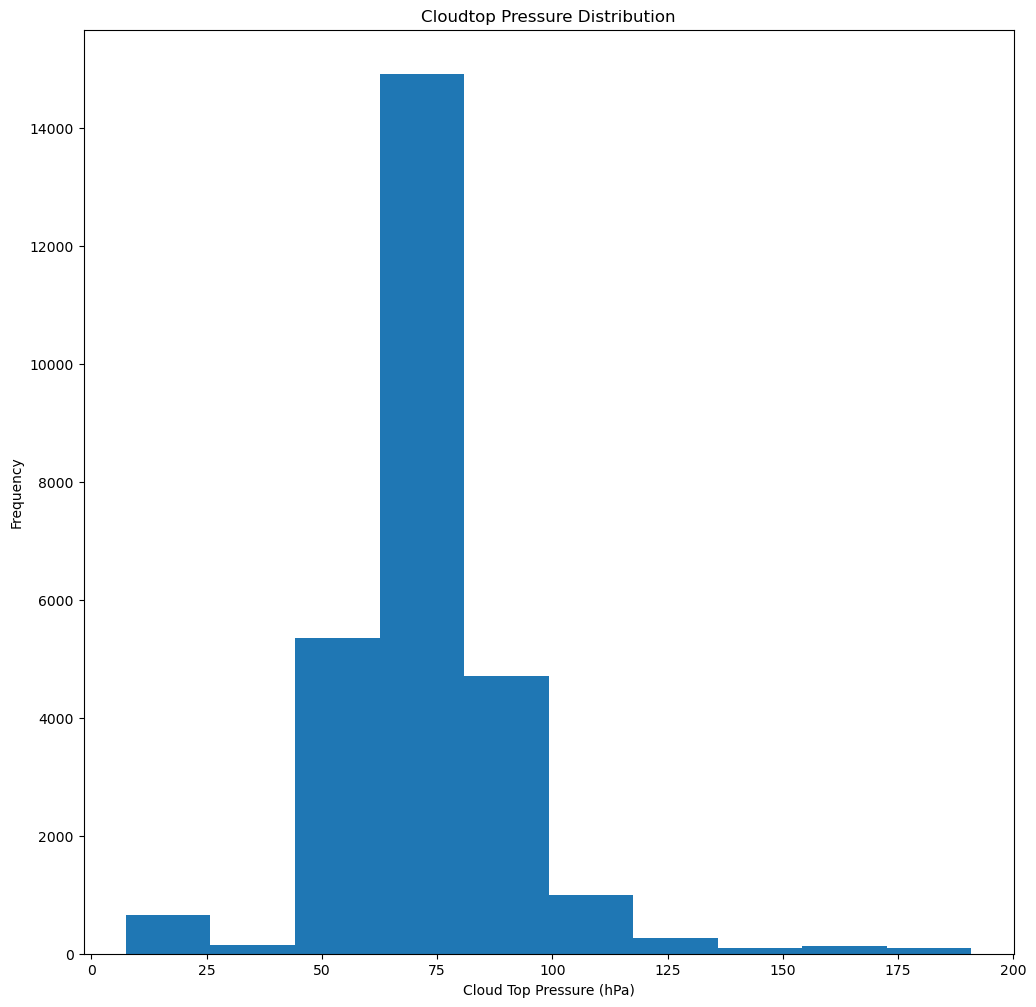

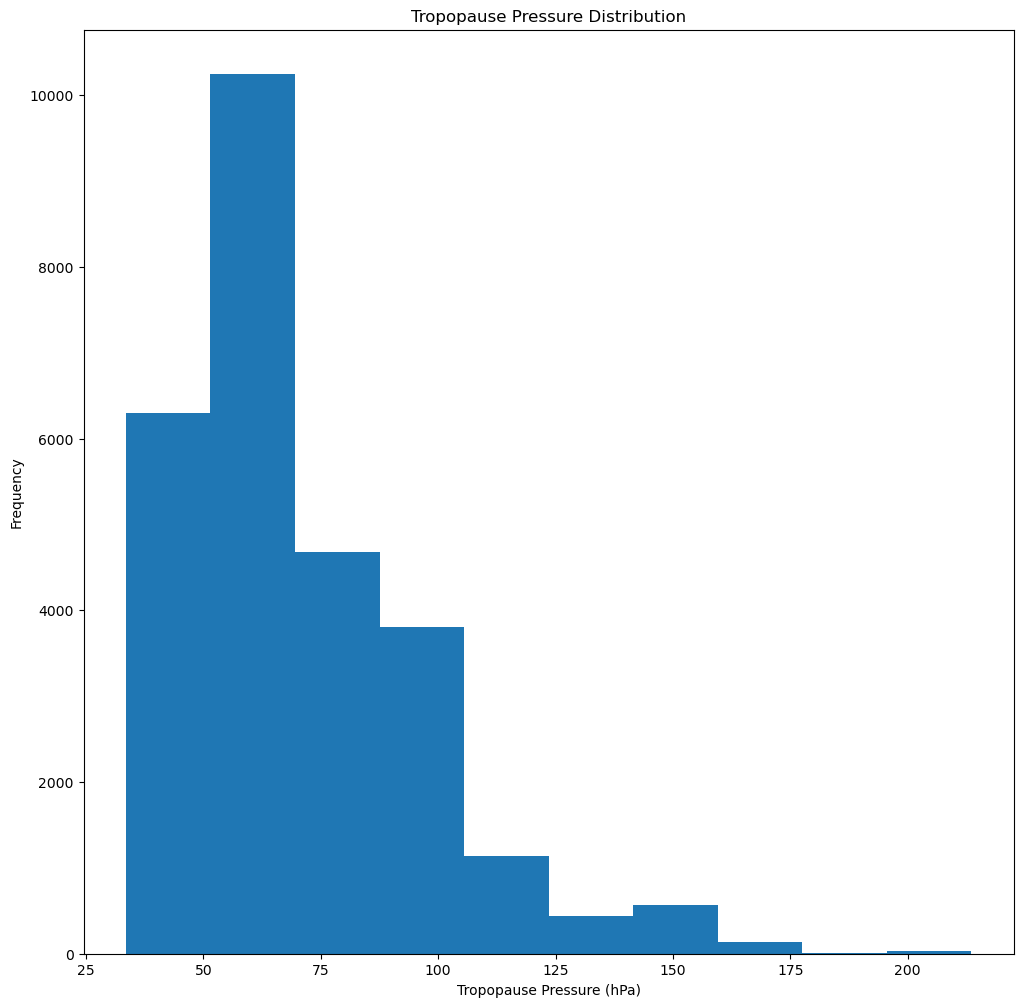

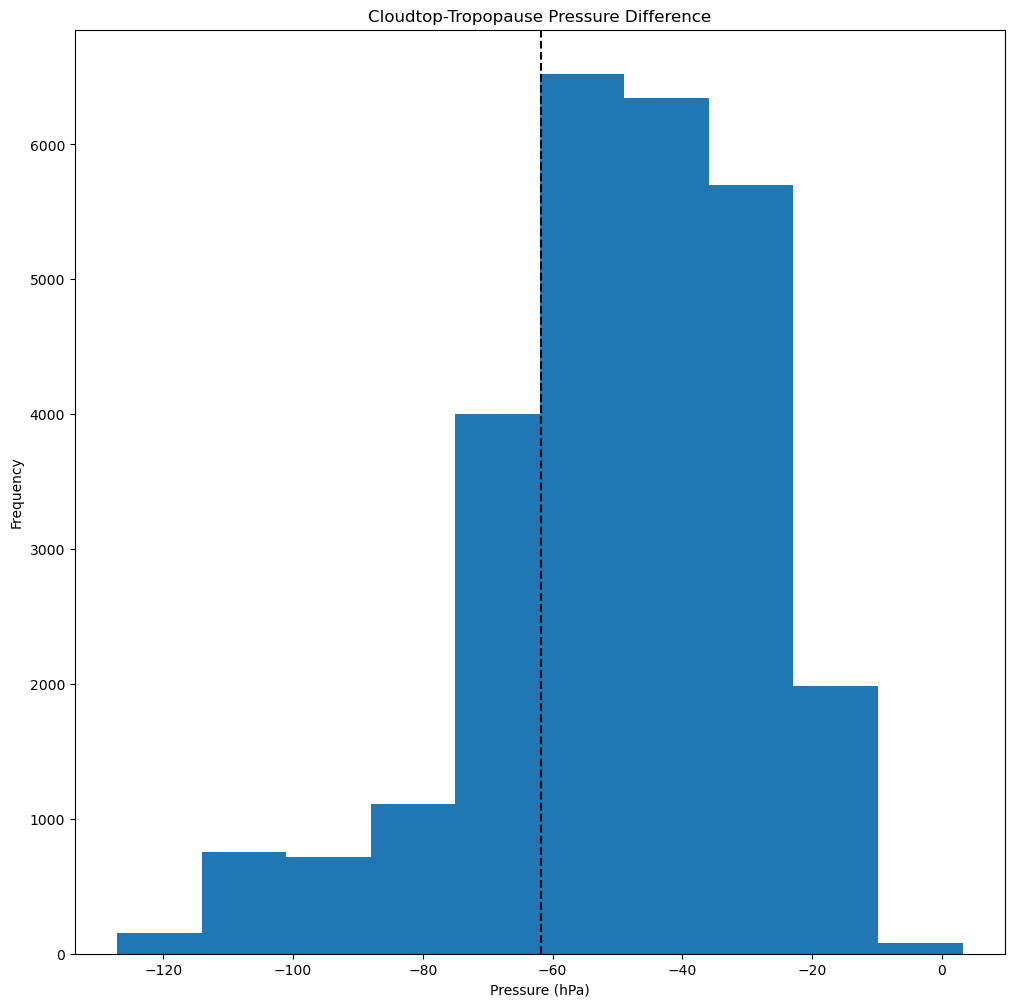

In [26]:
fig1, ax1 = plt.subplots(figsize=(12,12))
ax1.hist(cloudtop_pressure)
plt.title('Cloudtop Pressure Distribution')
plt.xlabel('Cloud Top Pressure (hPa)')
plt.ylabel('Frequency')

fig2, ax2 = plt.subplots(figsize=(12,12))
ax2.hist(obs_top)
plt.title('Tropopause Pressure Distribution')
plt.xlabel('Tropopause Pressure (hPa)')
plt.ylabel('Frequency')


percent_75 = np.percentile(cloud_trop_diff, 25)
fig2, ax3 = plt.subplots(figsize=(12,12))
ax3.hist(cloud_trop_diff)
plt.title('Cloudtop-Tropopause Pressure Difference')
plt.xlabel('Pressure (hPa)')
plt.ylabel('Frequency')
ax3.axvline(percent_75, color = 'black', ls = '--', label = '25th Percentil')